In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

'''

    RUMORE BGO + FUNZIONI VARIE
    
'''

rumore = pd.read_csv(r'C:\Users\Black\Desktop\Esperimentazioni di Nucleare e Subnucleare\SiPM\Caratterizzazione Cristalli\BGO\Fondo BGO\BGO-fondo-newgate.CSV', sep=';')

channel_back = np.array(rumore['Channel']) #taglio i dati per avere lo stesso numero di elementi
counts_back = np.array(rumore['Counts'])
time_back = 9218 #s
frequency_back = counts_back/time_back

allungo_x = np.arange(20510, 1000000, 20)
allungo_y = np.zeros(len(allungo_x))
channel_back = np.concatenate((channel_back, allungo_x))
counts_back = np.concatenate((counts_back, allungo_y))
frequency_back = np.concatenate((frequency_back, allungo_y))

def frequency_converter(counts, time_signal=180, frequency_back=frequency_back, time_background=time_back, counts_back=counts_back):
    frequency = counts/time_signal
    counts_back = counts_back [:len(frequency)]
    frequency_ = frequency - frequency_back[:len(frequency)]
    for i in range(len(frequency_)):
        if frequency_[i] < 0:
            frequency_[i] = 0
    error = np.sqrt(counts/time_signal**2 + counts_back/time_background**2)
    return frequency_, error

def SNIP_algorithm(spectrum, iterations=40):
    spectrum_log = np.log(np.log(np.sqrt(spectrum + 1) + 1) + 1)
    n_added = iterations
    begin_list = np.ones(n_added) * spectrum_log[0]
    end_list = np.ones(n_added) * spectrum_log[-1]
    spectrum_log = np.concatenate((begin_list, spectrum_log, end_list))
    for k in range(1, iterations+1, 1):
        for i in range(len(spectrum_log[n_added:-n_added])):
            spectrum_log[i] = np.minimum(spectrum_log[i], 0.5 * (spectrum_log[i+k] + spectrum_log[i-k]))
    return (np.exp(np.exp(spectrum_log[n_added:-n_added])-1)-1)**2-1

def trapz_integral(channel, frequency, integral_extremes):
    freq_integral = []
    channel_integral = []
    for i in range(len(channel)):
        if channel[i] > integral_extremes[0] and channel[i] < integral_extremes[1]:
            freq_integral.append(frequency[0][i])
            channel_integral.append(channel[i])
    integral = np.trapz(freq_integral, channel_integral)
    return integral


# funzioni per fit
from iminuit import Minuit
from iminuit.cost import LeastSquares
from scipy.stats import norm, chi2

def func(x, A, mu, sigma):
    return A * norm.pdf(x, mu, sigma)

def func2(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return A1 * norm.pdf(x, mu1, sigma1) + A2 * norm.pdf(x, mu2, sigma2)

def func3(x, A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3):
    return A1 * norm.pdf(x, mu1, sigma1) + A2 * norm.pdf(x, mu2, sigma2) + A3 * norm.pdf(x, mu3, sigma3)

intensità_511KeV = []
intensità_trapz_511KeV = []
err_intensità_511KeV = []
err_sistematico_511KeV = []

intensità_1274_5KeV = []
intensità_trapz_1274_5KeV = []
err_intensità_1274_5KeV = []
err_sistematico_1274_5KeV = []

In [2]:
'''

    ALLUMINIO 0cm

'''

segnale_0cm = pd.read_csv(r'C:\Users\Black\Desktop\Esperimentazioni di Nucleare e Subnucleare\SiPM\Spettrometria Gamma\BGO\Alluminio\Data\0cm.csv', sep=' \t', engine='python')
channel_0 = np.array(segnale_0cm['Channel'])
counts_0 = np.array(segnale_0cm['Counts'])

# calculating frequency and removing background noise
N = 16
frequency_0 = frequency_converter(counts_0, time_signal=300)
background_0 = SNIP_algorithm(frequency_0[0], iterations=N)
frequency_0 = (frequency_0[0] - background_0, frequency_0[1])

fig = px.line(x=channel_0, y=frequency_0[0], error_y=frequency_0[1], title='Spettro Na con alluminio di spessore 0cm', labels={'x':'Canale', 'y':'Frequenza [Hz]'})
fig.show()

ls = LeastSquares(channel_0, frequency_0[0], frequency_0[1], func2)
m = Minuit(ls, A1=2000, mu1=2500, sigma1=150, A2=500, mu2=2200, sigma2=200)
ls.mask = (channel_0 > 1850) & (channel_0 < 2850)
m.migrad()
m.hesse()
display(m)

freq_integral = []
channel_integral = []
integral_extremes = [1900, 2900]
for i in range(len(channel_0)):
    if channel_0[i] > integral_extremes[0] and channel_0[i] < integral_extremes[1]:
        freq_integral.append(frequency_0[0][i])
        channel_integral.append(channel_0[i])

area_tot = m.values['A1'] + m.values['A2']
err_area_tot = np.sqrt(m.errors['A1']**2 + m.errors['A2']**2)

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {area_tot:.2f} ± {err_area_tot:.2f}')

intensità_511KeV.append(area_tot)
intensità_trapz_511KeV.append(np.trapz(freq_integral, channel_integral))
err_intensità_511KeV.append(err_area_tot)


# calcolo errore sistematico DOWN
frequency_0 = frequency_converter(counts_0, time_signal=300)
background_0 = SNIP_algorithm(frequency_0[0], iterations=N+1)
frequency_0 = (frequency_0[0] - background_0, frequency_0[1])

ls = LeastSquares(channel_0, frequency_0[0], frequency_0[1], func2)
m = Minuit(ls, A1=500, mu1=2500, sigma1=400, A2=60, mu2=2200, sigma2=100)
ls.mask = (channel_0 > 1850) & (channel_0 < 2850)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_0 = frequency_converter(counts_0, time_signal=300)
background_0 = SNIP_algorithm(frequency_0[0], iterations=N-1)
frequency_0 = (frequency_0[0] - background_0, frequency_0[1])

ls = LeastSquares(channel_0, frequency_0[0], frequency_0[1], func2)
m = Minuit(ls, A1=470, mu1=2500, sigma1=400, A2=50, mu2=2200, sigma2=100)
ls.mask = (channel_0 > 1850) & (channel_0 < 2850)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_511KeV.append(err_sistematico)
print(f'Errore statistico: {err_area_tot:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 46.3 (χ²/ndof = 1.1)       │              Nfcn = 971              │
│ EDM = 3.51e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    470    │    22     │            │            │         │         │       │
│ 1 │ mu1    │  2.494e3  │  0.009e3  │            │            │         │         │       │
│ 2 │ sigma1 │    144    │     5     │            │            │         │         │       │
│ 3 │ A2     │    53     │    21     │            │            │         │         │       │
│ 4 │ mu2    │  2.16e3   │  0.05e3   │            │            │         │         │       │
│ 5 │ sigma2 │    119    │    30     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │      473     -170      107   -0.4e3   -1.0e3   -0.6e3 │
│    mu1 │     -170     73.3      -42      180      400      230 │
│ sigma1 │      107      -42     29.1     -107     -238     -136 │
│     A2 │   -0.4e3      180     -107      456    1.0e3    0.6e3 │
│    mu2 │   -1.0e3      400     -238    1.0e3 2.34e+03    1.4e3 │
│ sigma2 │   -0.6e3      230     -136    0.6e3    1.4e3      888 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 521.19
Area picco con integrale fit: 522.84 ± 30.47


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 45.95 (χ²/ndof = 1.1)      │              Nfcn = 308              │
│ EDM = 4.28e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    460    │    40     │            │            │         │         │       │
│ 1 │ mu1    │  2.499e3  │  0.013e3  │            │            │         │         │       │
│ 2 │ sigma1 │    141    │     6     │            │            │         │         │       │
│ 3 │ A2     │    70     │    40     │            │            │         │         │       │
│ 4 │ mu2    │  2.19e3   │  0.08e3   │            │            │         │         │       │
│ 5 │ sigma2 │    150    │    40     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │ 1.64e+03  -0.52e3      240   -1.6e3   -3.2e3   -1.5e3 │
│    mu1 │  -0.52e3      170      -80   0.52e3   1.02e3   0.48e3 │
│ sigma1 │      240      -80     39.8     -240     -470     -220 │
│     A2 │   -1.6e3   0.52e3     -240 1.65e+03    3.2e3    1.6e3 │
│    mu2 │   -3.2e3   1.02e3     -470    3.2e3 6.42e+03    3.1e3 │
│ sigma2 │   -1.5e3   0.48e3     -220    1.6e3    3.1e3 1.58e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 530.36


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 45.38 (χ²/ndof = 1.1)      │              Nfcn = 900              │
│ EDM = 3.34e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    45     │    16     │            │            │         │         │       │
│ 1 │ mu1    │  2.15e3   │  0.04e3   │            │            │         │         │       │
│ 2 │ sigma1 │    108    │    27     │            │            │         │         │       │
│ 3 │ A2     │    472    │    17     │            │            │         │         │       │
│ 4 │ mu2    │  2.492e3  │  0.007e3  │            │            │         │         │       │
│ 5 │ sigma2 │    145    │     5     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │      267   0.61e3   0.42e3  -0.26e3      110      -72 │
│    mu1 │   0.61e3 1.51e+03    1.0e3  -0.60e3      250     -168 │
│ sigma1 │   0.42e3    1.0e3      730  -0.40e3      170     -108 │
│     A2 │  -0.26e3  -0.60e3  -0.40e3      287     -110       73 │
│    mu2 │      110      250      170     -110     49.2      -30 │
│ sigma2 │      -72     -168     -108       73      -30     23.4 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 517.03
Errore statistico: 30.47
Errore sistematico: 6.67


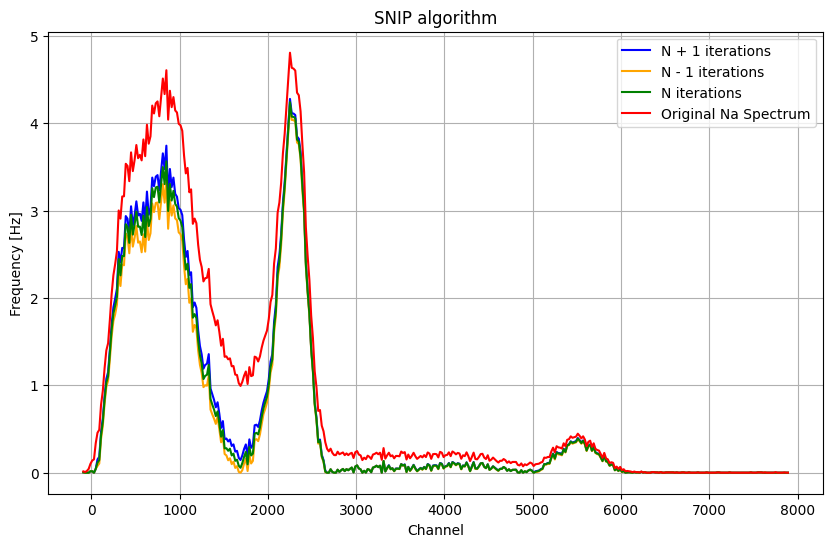

In [3]:
# uso 1cm come esempio di SNIP

segnale_0cm = pd.read_csv(r'C:\Users\Black\Desktop\Esperimentazioni di Nucleare e Subnucleare\SiPM\Spettrometria Gamma\BGO\Alluminio\Data\1cm.csv', sep=' \t', engine='python')
channel_0 = np.array(segnale_0cm['Channel'])[0:400]
counts_0 = np.array(segnale_0cm['Counts'])[0:400]
frequency_0_spettro = frequency_converter(counts_0, time_signal=300)[0:400]

# calculating frequency and removing background noise
N = 14
frequency_0 = frequency_converter(counts_0, time_signal=300)
background_0 = SNIP_algorithm(frequency_0[0], iterations=N)
frequency_0 = (frequency_0[0] - background_0, frequency_0[1])


# SNIP DOWN
frequency_0d = frequency_converter(counts_0, time_signal=300)
background_0d = SNIP_algorithm(frequency_0d[0], iterations=N+1)
frequency_0d = (frequency_0d[0] - background_0d, frequency_0d[1])

# SNIP UP
frequency_0u = frequency_converter(counts_0, time_signal=300)
background_0u = SNIP_algorithm(frequency_0u[0], iterations=N-1)
frequency_0u = (frequency_0u[0] - background_0u, frequency_0u[1])

# plot SNIPs su spettro originale
plt.subplots(figsize=(10, 6))
plt.plot(channel_0, frequency_0d[0], label='N + 1 iterations', color='blue')
plt.plot(channel_0, frequency_0u[0], label='N - 1 iterations',  color='orange')
plt.plot(channel_0, frequency_0[0], label='N iterations', color='green')
plt.plot(channel_0, frequency_0_spettro[0], label='Original Na Spectrum', color='red')
plt.xlabel('Channel')
plt.ylabel('Frequency [Hz]')
plt.title('SNIP algorithm')
plt.legend()
plt.grid()
plt.show()

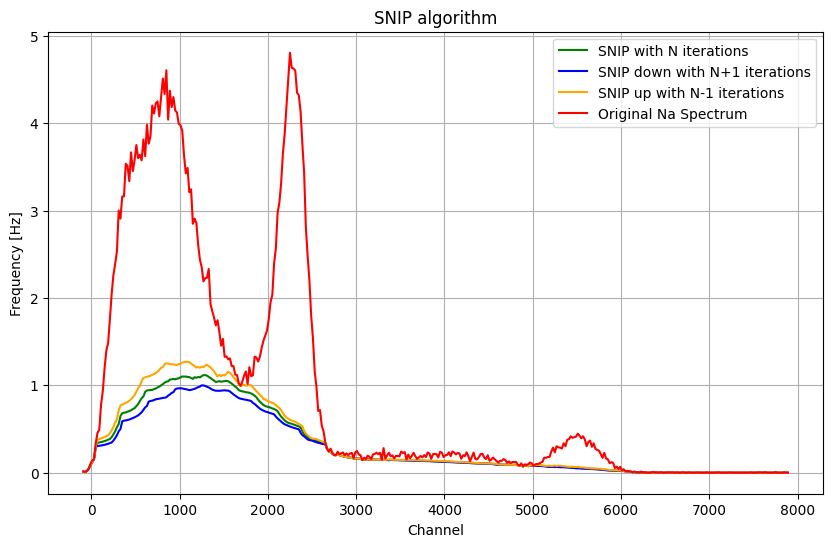

In [4]:
plt.subplots(figsize=(10, 6))
plt.plot(channel_0, background_0, label='SNIP with N iterations', color='green')
plt.plot(channel_0, background_0d, label='SNIP down with N+1 iterations', color='blue')
plt.plot(channel_0, background_0u, label='SNIP up with N-1 iterations', color='orange')
plt.plot(channel_0, frequency_0_spettro[0], label='Original Na Spectrum', color='red')
plt.xlabel('Channel')
plt.ylabel('Frequency [Hz]')
plt.title('SNIP algorithm')
plt.legend()
plt.grid()
plt.show()

In [5]:
segnale_0cm = pd.read_csv(r'C:\Users\Black\Desktop\Esperimentazioni di Nucleare e Subnucleare\SiPM\Spettrometria Gamma\BGO\Alluminio\Data\0cm.csv', sep=' \t', engine='python')
channel_0 = np.array(segnale_0cm['Channel'])[0:400]
counts_0 = np.array(segnale_0cm['Counts'])[0:400]

N = 13
frequency_0 = frequency_converter(counts_0, time_signal=300)
background_0 = SNIP_algorithm(frequency_0[0], iterations=N)
frequency_0 = (frequency_0[0] - background_0, frequency_0[1])

# fit
ls = LeastSquares(channel_0, frequency_0[0], frequency_0[1], func2)
m = Minuit(ls, A1=57, mu1=6000, sigma1=400, A2=24, mu2=4740, sigma2=800)
ls.mask = (channel_0 > 4700) & (channel_0 < 6350)
m.migrad()
m.hesse()
display(m)

freq_integral = []
channel_integral = []
integral_extremes = [5300, 6400]
for i in range(len(channel_0)):
    if channel_0[i] > integral_extremes[0] and channel_0[i] < integral_extremes[1]:
        freq_integral.append(frequency_0[0][i])
        channel_integral.append(channel_0[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A1"]:.2f} ± {m.errors["A1"]:.2f}')

intensità_1274_5KeV.append(m.values['A1'])
intensità_trapz_1274_5KeV.append(np.trapz(freq_integral, channel_integral))
err_intensità_1274_5KeV.append(m.errors['A1'])

# calcolo errore sistematico DOWN
frequency_0 = frequency_converter(counts_0, time_signal=300)
background_0 = SNIP_algorithm(frequency_0[0], iterations=N+1)
frequency_0 = (frequency_0[0] - background_0, frequency_0[1])

ls = LeastSquares(channel_0, frequency_0[0], frequency_0[1], func2)
m = Minuit(ls, A1=57, mu1=6000, sigma1=400, A2=24, mu2=4740, sigma2=800)
ls.mask = (channel_0 > 4700) & (channel_0 < 6350)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1']
print(f'Area picco con integrale fit: {area_down:.2f}')


# calcolo errore sistematico UP
frequency_0 = frequency_converter(counts_0, time_signal=300)
background_0 = SNIP_algorithm(frequency_0[0], iterations=N-1)
frequency_0 = (frequency_0[0] - background_0, frequency_0[1])

ls = LeastSquares(channel_0, frequency_0[0], frequency_0[1], func2)
m = Minuit(ls, A1=57, mu1=6000, sigma1=400, A2=24, mu2=4740, sigma2=800)
ls.mask = (channel_0 > 4700) & (channel_0 < 6350)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_1274_5KeV.append(err_sistematico)
print(f'Errore statistico: {m.errors["A1"]:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}') # 65.96

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 81.86 (χ²/ndof = 1.1)      │              Nfcn = 293              │
│ EDM = 4.53e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   57.7    │    2.6    │            │            │         │         │       │
│ 1 │ mu1    │  5.967e3  │  0.012e3  │            │            │         │         │       │
│ 2 │ sigma1 │    243    │    13     │            │            │         │         │       │
│ 3 │ A2     │    25     │    26     │            │            │         │         │       │
│ 4 │ mu2    │   4.6e3   │   0.4e3   │            │            │         │         │       │
│ 5 │ sigma2 │  0.34e3   │  0.18e3   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     6.53        2       15      -16      232     -130 │
│    mu1 │        2      150   0.02e3   0.05e3  -0.78e3   0.43e3 │
│ sigma1 │       15   0.02e3      162  -0.11e3   1.56e3  -0.90e3 │
│     A2 │      -16   0.05e3  -0.11e3      663   -9.8e3    4.6e3 │
│    mu2 │      232  -0.78e3   1.56e3   -9.8e3 1.46e+05 -0.069e6 │
│ sigma2 │     -130   0.43e3  -0.90e3    4.6e3 -0.069e6 3.42e+04 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 58.09
Area picco con integrale fit: 57.69 ± 2.56


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 82.49 (χ²/ndof = 1.1)      │              Nfcn = 291              │
│ EDM = 4.64e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   60.2    │    2.6    │            │            │         │         │       │
│ 1 │ mu1    │  5.964e3  │  0.012e3  │            │            │         │         │       │
│ 2 │ sigma1 │    247    │    12     │            │            │         │         │       │
│ 3 │ A2     │    25     │    24     │            │            │         │         │       │
│ 4 │ mu2    │  4.63e3   │  0.34e3   │            │            │         │         │       │
│ 5 │ sigma2 │  0.32e3   │  0.17e3   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     6.56        3       15      -15      201     -115 │
│    mu1 │        3      143   0.02e3   0.05e3  -0.64e3   0.35e3 │
│ sigma1 │       15   0.02e3      157  -0.10e3   1.37e3  -0.80e3 │
│     A2 │      -15   0.05e3  -0.10e3      578   -8.2e3    3.9e3 │
│    mu2 │      201  -0.64e3   1.37e3   -8.2e3 1.19e+05 -0.057e6 │
│ sigma2 │     -115   0.35e3  -0.80e3    3.9e3 -0.057e6 2.84e+04 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 60.16


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 81.26 (χ²/ndof = 1.1)      │              Nfcn = 306              │
│ EDM = 2.7e-06 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   54.4    │    2.6    │            │            │         │         │       │
│ 1 │ mu1    │  5.971e3  │  0.013e3  │            │            │         │         │       │
│ 2 │ sigma1 │    237    │    13     │            │            │         │         │       │
│ 3 │ A2     │    25     │    28     │            │            │         │         │       │
│ 4 │ mu2    │   4.6e3   │   0.4e3   │            │            │         │         │       │
│ 5 │ sigma2 │  0.35e3   │  0.21e3   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     6.49        1       16      -18      279     -154 │
│    mu1 │        1      159   0.02e3   0.07e3  -1.02e3   0.55e3 │
│ sigma1 │       16   0.02e3      170  -0.12e3   1.83e3  -1.03e3 │
│     A2 │      -18   0.07e3  -0.12e3      795  -12.3e3    5.7e3 │
│    mu2 │      279  -1.02e3   1.83e3  -12.3e3 1.91e+05  -0.09e6 │
│ sigma2 │     -154   0.55e3  -1.03e3    5.7e3  -0.09e6 4.38e+04 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 54.43
Errore statistico: 2.55
Errore sistematico: 2.87


In [6]:
'''

    ALLUMINIO 0.4CM

'''

segnale_04cm = pd.read_csv(r'C:\Users\Black\Desktop\Esperimentazioni di Nucleare e Subnucleare\SiPM\Spettrometria Gamma\BGO\Alluminio\Data\0.4cm.csv', sep=' \t', engine='python')
channel_04 = np.array(segnale_04cm['Channel'])
counts_04 = np.array(segnale_04cm['Counts'])

# calculating frequency and removing background noise
N = 15
frequency_04 = frequency_converter(counts_04, time_signal=1000)
background_04 = SNIP_algorithm(frequency_04[0], iterations=N)
frequency_04 = (frequency_04[0] - background_04, frequency_04[1])

# plot
fig = px.line(x=channel_04, y=frequency_04[0], error_y=frequency_04[1], title='Spettro Na con alluminio di spessore 0.4cm', labels={'x':'Canale', 'y':'Frequenza [Hz]'})
fig.show()

trapz_integral_04 = trapz_integral(channel_04, frequency_04, [1700, 2650])

ls = LeastSquares(channel_04, frequency_04[0], frequency_04[1], func3)
m = Minuit(ls, A1=trapz_integral_04, mu1=2300, sigma1=400, A2=trapz_integral_04*0.1, mu2=2000, sigma2=100, A3=trapz_integral_04*0.2, mu3=1250, sigma3=200)
ls.mask = (channel_04 > 1250) & (channel_04 < 2650)
m.migrad()
m.hesse()
display(m)

area_tot = m.values['A1'] + m.values['A2']
err_area_tot = np.sqrt(m.errors['A1']**2 + m.errors['A2']**2)

print(f'Area picco con integrale trapezoidale: {trapz_integral_04:.2f}')
print(f'Area picco con integrale fit: {area_tot} ± {err_area_tot:.2f}')

intensità_511KeV.append(area_tot)
err_intensità_511KeV.append(err_area_tot)
intensità_trapz_511KeV.append(trapz_integral_04)


# calcolo errore sistematico DOWN
frequency_04 = frequency_converter(counts_04, time_signal=1000)
background_04 = SNIP_algorithm(frequency_04[0], iterations=N+1)
frequency_04 = (frequency_04[0] - background_04, frequency_04[1])

trapz_integral_04 = trapz_integral(channel_04, frequency_04, [1700, 2650])

ls = LeastSquares(channel_04, frequency_04[0], frequency_04[1], func3)
m = Minuit(ls, A1=trapz_integral_04, mu1=2300, sigma1=400, A2=trapz_integral_04*0.1, mu2=2000, sigma2=100, A3=trapz_integral_04*0.2, mu3=1250, sigma3=200)
ls.mask = (channel_04 > 1250) & (channel_04 < 2650)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_04 = frequency_converter(counts_04, time_signal=1000)
background_04 = SNIP_algorithm(frequency_04[0], iterations=N-1)
frequency_04 = (frequency_04[0] - background_04, frequency_04[1])

trapz_integral_04 = trapz_integral(channel_04, frequency_04, [1700, 2650])

ls = LeastSquares(channel_04, frequency_04[0], frequency_04[1], func3)
m = Minuit(ls, A1=trapz_integral_04, mu1=2300, sigma1=400, A2=trapz_integral_04*0.1, mu2=2000, sigma2=100, A3=trapz_integral_04*0.2, mu3=1250, sigma3=200)
ls.mask = (channel_04 > 1250) & (channel_04 < 2650)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_511KeV.append(err_sistematico)
print(f'Errore statistico: {err_area_tot:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 63.21 (χ²/ndof = 1.1)      │              Nfcn = 795              │
│ EDM = 6e-05 (Goal: 0.0002)       │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    413    │     6     │            │            │         │         │       │
│ 1 │ mu1    │ 2.2835e3  │ 0.0029e3  │            │            │         │         │       │
│ 2 │ sigma1 │   137.0   │    2.1    │            │            │         │         │       │
│ 3 │ A2     │    33     │     6     │            │            │         │         │       │
│ 4 │ mu2    │  1.957e3  │  0.017e3  │            │            │         │         │       │
│ 5 │ sigma2 │    97     │    14     │            │            │         │         │       │
│ 6 │ A3     │  0.28e3   │  0.13e3   │            │            │         │         │       │
│ 7 │ mu3    │  1.09e3   │  0.12e3   │            │            │         │         │       │
│ 8 │ sigma3 │    250    │    40     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬──────────────────────────────────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2       A3      mu3   sigma3 │
├────────┼──────────────────────────────────────────────────────────────────────────────────┤
│     A1 │     41.9      -15       11      -30      -90      -70      160     -140       60 │
│    mu1 │      -15      8.3       -5       16       41       31      -72       65      -27 │
│ sigma1 │       11       -5     4.45      -11      -28      -21       45      -41       17 │
│     A2 │      -30       16      -11     38.1       90       80     -240      220      -90 │
│    mu2 │      -90       41      -28       90      279   0.18e3  -0.24e3   0.22e3  -0.09e3 │
│ sigma2 │      -70       31      -21       80   0.18e3      190  -0.58e3   0.53e3  -0.22e3 │
│     A3 │      160      -72       45     -240  -0.24e3  -0.58e3 1.62e+04 -0.015e6    5.4e3 │
│    mu3 │     -140       65      -41      220   0.22e3   0.53e3 -0.015e6 1.32e+04   -4.9e3 │
│ sigma3 │       60      -27       17      -90  -0.09e3  -0.22e3    5.4e3   -4.9e3 1.86e+03 │
└────────┴──────────────────────────────────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 446.02
Area picco con integrale fit: 446.21168426890785 ± 8.95


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 59.07 (χ²/ndof = 1.0)      │             Nfcn = 1019              │
│ EDM = 1.63e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    416    │     8     │            │            │         │         │       │
│ 1 │ mu1    │ 2.2841e3  │ 0.0035e3  │            │            │         │         │       │
│ 2 │ sigma1 │   137.1   │    2.4    │            │            │         │         │       │
│ 3 │ A2     │    39     │     8     │            │            │         │         │       │
│ 4 │ mu2    │  1.958e3  │  0.020e3  │            │            │         │         │       │
│ 5 │ sigma2 │    107    │    16     │            │            │         │         │       │
│ 6 │ A3     │   0.5e3   │   0.4e3   │            │            │         │         │       │
│ 7 │ mu3    │  0.93e3   │  0.23e3   │            │            │         │         │       │
│ 8 │ sigma3 │    320    │    80     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬──────────────────────────────────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2       A3      mu3   sigma3 │
├────────┼──────────────────────────────────────────────────────────────────────────────────┤
│     A1 │     64.8      -24       16      -60     -140     -110      860     -500      170 │
│    mu1 │      -24     12.2       -7       27       63       47     -375      217      -76 │
│ sigma1 │       16       -7     5.62      -17      -40      -28      221     -128       45 │
│     A2 │      -60       27      -17     70.1      150      120  -1.47e3      850     -290 │
│    mu2 │     -140       63      -40      150      405   0.27e3   -1.2e3    0.7e3   -0.3e3 │
│ sigma2 │     -110       47      -28      120   0.27e3      256  -2.82e3   1.63e3  -0.57e3 │
│     A3 │      860     -375      221  -1.47e3   -1.2e3  -2.82e3 1.71e+05  -0.10e6     31e3 │
│    mu3 │     -500      217     -128      850    0.7e3   1.63e3  -0.10e6 5.52e+04    -18e3 │
│ sigma3 │      170      -76       45     -290   -0.3e3  -0.57e3     31e3    -18e3  5.8e+03 │
└────────┴──────────────────────────────────────────────────────────────────────────────────┘

Area picco con integrale fit: 455.15


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 66.26 (χ²/ndof = 1.1)      │              Nfcn = 633              │
│ EDM = 7.07e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    410    │     5     │            │            │         │         │       │
│ 1 │ mu1    │ 2.2829e3  │ 0.0023e3  │            │            │         │         │       │
│ 2 │ sigma1 │   136.9   │    1.8    │            │            │         │         │       │
│ 3 │ A2     │    27     │     4     │            │            │         │         │       │
│ 4 │ mu2    │  1.958e3  │  0.013e3  │            │            │         │         │       │
│ 5 │ sigma2 │    85     │    11     │            │            │         │         │       │
│ 6 │ A3     │    170    │    50     │            │            │         │         │       │
│ 7 │ mu3    │  1.18e3   │  0.06e3   │            │            │         │         │       │
│ 8 │ sigma3 │    196    │    27     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬──────────────────────────────────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2       A3      mu3   sigma3 │
├────────┼──────────────────────────────────────────────────────────────────────────────────┤
│     A1 │     26.8       -8      6.9      -17      -50      -39       19      -24       12 │
│    mu1 │       -8     5.43     -3.2        9       25       19       -9       12       -6 │
│ sigma1 │      6.9     -3.2     3.42     -6.6    -18.3    -13.3      6.3     -8.0      3.9 │
│     A2 │      -17        9     -6.6     19.7       49       43      -28       36      -17 │
│    mu2 │      -50       25    -18.3       49      180   0.11e3  -0.03e3   0.04e3  -0.02e3 │
│ sigma2 │      -39       19    -13.3       43   0.11e3      126  -0.09e3   0.11e3  -0.05e3 │
│     A3 │       19       -9      6.3      -28  -0.03e3  -0.09e3  2.5e+03   -3.2e3    1.3e3 │
│    mu3 │      -24       12     -8.0       36   0.04e3   0.11e3   -3.2e3 4.04e+03   -1.7e3 │
│ sigma3 │       12       -6      3.9      -17  -0.02e3  -0.05e3    1.3e3   -1.7e3      748 │
└────────┴──────────────────────────────────────────────────────────────────────────────────┘

Area picco con integrale fit: 437.22
Errore statistico: 8.95
Errore sistematico: 8.97


In [7]:
# fit
N = 13
frequency_04 = frequency_converter(counts_04, time_signal=1000)
background_04 = SNIP_algorithm(frequency_04[0], iterations=N+1)
frequency_04 = (frequency_04[0] - background_04, frequency_04[1])
trapz_integral_04 = trapz_integral(channel_04, frequency_04, [4000, 5700])

ls = LeastSquares(channel_04, frequency_04[0], frequency_04[1], func2)
m = Minuit(ls, A1=trapz_integral_04*1.2, mu1=5300, sigma1=215, A2=trapz_integral_04*0.1, mu2=4200, sigma2=270)
ls.mask = (channel_04 > 4100) & (channel_04 < 6000)
m.migrad()
m.hesse()
display(m)

area_tot = m.values['A1']+4
err_area_tot = m.errors['A1']

print(f'Area picco con integrale trapezoidale: {trapz_integral_04:.2f}')
print(f'Area picco con integrale fit: {area_tot} ± {err_area_tot:.2f}')

intensità_1274_5KeV.append(area_tot)
err_intensità_1274_5KeV.append(err_area_tot)
intensità_trapz_1274_5KeV.append(trapz_integral_04)


# calcolo errore sistematico DOWN
frequency_04 = frequency_converter(counts_04, time_signal=1000)
background_04 = SNIP_algorithm(frequency_04[0], iterations=N+1)
frequency_04 = (frequency_04[0] - background_04, frequency_04[1])

trapz_integral_04 = trapz_integral(channel_04, frequency_04, [4000, 5700])

ls = LeastSquares(channel_04, frequency_04[0], frequency_04[1], func2)
m = Minuit(ls, A1=trapz_integral_04*1.2, mu1=5300, sigma1=400, A2=trapz_integral_04*0.1, mu2=4200, sigma2=800)
ls.mask = (channel_04 > 4100) & (channel_04 < 6000)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1']+4
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_04 = frequency_converter(counts_04, time_signal=1000)
background_04 = SNIP_algorithm(frequency_04[0], iterations=N-1)
frequency_04 = (frequency_04[0] - background_04, frequency_04[1])

trapz_integral_04 = trapz_integral(channel_04, frequency_04, [4000, 5700])

ls = LeastSquares(channel_04, frequency_04[0], frequency_04[1], func2)
m = Minuit(ls, A1=trapz_integral_04*1.2, mu1=5300, sigma1=400, A2=trapz_integral_04*0.1, mu2=4200, sigma2=800)
ls.mask = (channel_04 > 4100) & (channel_04 < 6000)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1']+4
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_1274_5KeV.append(err_sistematico)
print(f'Errore statistico: {err_area_tot:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 96.61 (χ²/ndof = 1.1)      │              Nfcn = 248              │
│ EDM = 4.92e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   51.6    │    1.2    │            │            │         │         │       │
│ 1 │ mu1    │  5.512e3  │  0.006e3  │            │            │         │         │       │
│ 2 │ sigma1 │    215    │     5     │            │            │         │         │       │
│ 3 │ A2     │   14.9    │    1.9    │            │            │         │         │       │
│ 4 │ mu2    │  4.33e3   │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │    270    │    40     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     1.39     -0.7      1.4     -0.2      2.2     -4.5 │
│    mu1 │     -0.7     31.6       -5      1.2      -15       31 │
│ sigma1 │      1.4       -5     21.6     -1.3       15      -33 │
│     A2 │     -0.2      1.2     -1.3     3.48    -61.2     57.9 │
│    mu2 │      2.2      -15       15    -61.2 1.92e+03   -1.2e3 │
│ sigma2 │     -4.5       31      -33     57.9   -1.2e3  1.4e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 55.90
Area picco con integrale fit: 55.581926828613085 ± 1.18


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 96.61 (χ²/ndof = 1.1)      │              Nfcn = 658              │
│ EDM = 2.51e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   51.6    │    1.2    │            │            │         │         │       │
│ 1 │ mu1    │  5.512e3  │  0.006e3  │            │            │         │         │       │
│ 2 │ sigma1 │    215    │     5     │            │            │         │         │       │
│ 3 │ A2     │   14.9    │    1.9    │            │            │         │         │       │
│ 4 │ mu2    │  4.33e3   │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │    270    │    40     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     1.39     -0.7      1.4     -0.2      2.2     -4.5 │
│    mu1 │     -0.7     31.6       -5      1.3      -15       31 │
│ sigma1 │      1.4       -5     21.6     -1.3       15      -33 │
│     A2 │     -0.2      1.3     -1.3     3.48    -61.2     57.9 │
│    mu2 │      2.2      -15       15    -61.2 1.92e+03   -1.2e3 │
│ sigma2 │     -4.5       31      -33     57.9   -1.2e3  1.4e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 55.59


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 98.19 (χ²/ndof = 1.1)      │              Nfcn = 453              │
│ EDM = 6.73e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   47.2    │    1.2    │            │            │         │         │       │
│ 1 │ mu1    │  5.517e3  │  0.006e3  │            │            │         │         │       │
│ 2 │ sigma1 │    208    │     5     │            │            │         │         │       │
│ 3 │ A2     │   13.7    │    1.8    │            │            │         │         │       │
│ 4 │ mu2    │  4.34e3   │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │    270    │    40     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     1.38     -0.8      1.5     -0.2      2.0     -4.4 │
│    mu1 │     -0.8     35.4       -6      1.2      -14       32 │
│ sigma1 │      1.5       -6     23.6     -1.2       14      -34 │
│     A2 │     -0.2      1.2     -1.2     3.12    -57.3     56.1 │
│    mu2 │      2.0      -14       14    -57.3 2.01e+03   -1.3e3 │
│ sigma2 │     -4.4       32      -34     56.1   -1.3e3 1.53e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 51.20
Errore statistico: 1.18
Errore sistematico: 2.19


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 64.88 (χ²/ndof = 1.1)      │              Nfcn = 910              │
│ EDM = 0.000199 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    303    │    25     │            │            │         │         │       │
│ 1 │ mu1    │  2.302e3  │  0.005e3  │            │            │         │         │       │
│ 2 │ sigma1 │   128.7   │    2.8    │            │            │         │         │       │
│ 3 │ A2     │    97     │    25     │            │            │         │         │       │
│ 4 │ mu2    │  2.09e3   │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │    179    │    16     │            │            │         │         │       │
│ 6 │ A3     │    170    │    50     │            │            │         │         │       │
│ 7 │ mu3    │  1.18e3   │  0.07e3   │            │            │         │         │       │
│ 8 │ sigma3 │    212    │    32     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬──────────────────────────────────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2       A3      mu3   sigma3 │
├────────┼──────────────────────────────────────────────────────────────────────────────────┤
│     A1 │      620      -93       58   -0.6e3   -1.0e3  -0.28e3   -0.1e3    0.1e3       -0 │
│    mu1 │      -93     20.7      -11       91      147       19       52      -68       37 │
│ sigma1 │       58      -11     7.64      -56      -91      -17      -20       26      -14 │
│     A2 │   -0.6e3       91      -56      613    1.0e3   0.30e3        0       -0        0 │
│    mu2 │   -1.0e3      147      -91    1.0e3 1.81e+03   0.52e3    0.1e3   -0.2e3    0.1e3 │
│ sigma2 │  -0.28e3       19      -17   0.30e3   0.52e3      257  -0.22e3   0.28e3  -0.16e3 │
│     A3 │   -0.1e3       52      -20        0    0.1e3  -0.22e3 2.49e+03   -3.3e3    1.5e3 │
│    mu3 │    0.1e3      -68       26       -0   -0.2e3   0.28e3   -3.3e3 4.39e+03   -2.0e3 │
│ sigma3 │       -0       37      -14        0    0.1e3  -0.16e3    1.5e3   -2.0e3    1e+03 │
└────────┴──────────────────────────────────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 398.75
Area picco con integrale fit: 400.2887069093773 ± 35.11


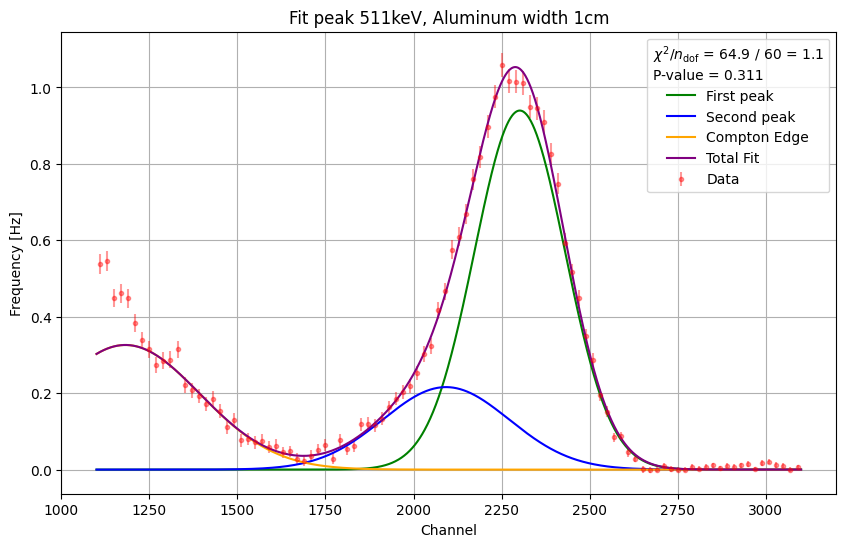

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 68.25 (χ²/ndof = 1.1)      │              Nfcn = 821              │
│ EDM = 9.89e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    311    │    24     │            │            │         │         │       │
│ 1 │ mu1    │  2.300e3  │  0.004e3  │            │            │         │         │       │
│ 2 │ sigma1 │   130.0   │    2.7    │            │            │         │         │       │
│ 3 │ A2     │    100    │    24     │            │            │         │         │       │
│ 4 │ mu2    │  2.08e3   │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │    185    │    18     │            │            │         │         │       │
│ 6 │ A3     │  0.28e3   │  0.13e3   │            │            │         │         │       │
│ 7 │ mu3    │  1.09e3   │  0.13e3   │            │            │         │         │       │
│ 8 │ sigma3 │    270    │    50     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬──────────────────────────────────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2       A3      mu3   sigma3 │
├────────┼──────────────────────────────────────────────────────────────────────────────────┤
│     A1 │      582      -87       56   -0.6e3   -1.0e3  -0.30e3   -0.3e3    0.3e3   -0.1e3 │
│    mu1 │      -87     19.5      -11       83      149       19      171     -167       77 │
│ sigma1 │       56      -11     7.52      -54      -94      -18      -67       66      -30 │
│     A2 │   -0.6e3       83      -54      577    1.0e3   0.33e3        0       -0        0 │
│    mu2 │   -1.0e3      149      -94    1.0e3 1.85e+03   0.54e3    0.8e3   -0.8e3    0.3e3 │
│ sigma2 │  -0.30e3       19      -18   0.33e3   0.54e3      319  -0.81e3   0.79e3  -0.37e3 │
│     A3 │   -0.3e3      171      -67        0    0.8e3  -0.81e3 1.65e+04 -0.016e6    6.7e3 │
│    mu3 │    0.3e3     -167       66       -0   -0.8e3   0.79e3 -0.016e6 1.58e+04   -6.6e3 │
│ sigma3 │   -0.1e3       77      -30        0    0.3e3  -0.37e3    6.7e3   -6.6e3 2.83e+03 │
└────────┴──────────────────────────────────────────────────────────────────────────────────┘

Area picco con integrale fit: 411.12


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 63.38 (χ²/ndof = 1.1)      │              Nfcn = 820              │
│ EDM = 5.23e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    290    │    30     │            │            │         │         │       │
│ 1 │ mu1    │  2.305e3  │  0.005e3  │            │            │         │         │       │
│ 2 │ sigma1 │   126.8   │    3.0    │            │            │         │         │       │
│ 3 │ A2     │    99     │    30     │            │            │         │         │       │
│ 4 │ mu2    │  2.11e3   │  0.05e3   │            │            │         │         │       │
│ 5 │ sigma2 │    169    │    15     │            │            │         │         │       │
│ 6 │ A3     │    113    │    23     │            │            │         │         │       │
│ 7 │ mu3    │  1.24e3   │  0.04e3   │            │            │         │         │       │
│ 8 │ sigma3 │    168    │    21     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬──────────────────────────────────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2       A3      mu3   sigma3 │
├────────┼──────────────────────────────────────────────────────────────────────────────────┤
│     A1 │      911     -140       76   -0.9e3   -1.3e3  -0.34e3       -0        0       -0 │
│    mu1 │     -140     29.4      -15      138      192       29       12      -20       13 │
│ sigma1 │       76      -15     8.99      -75     -104      -19       -5        7       -5 │
│     A2 │   -0.9e3      138      -75      903    1.3e3   0.35e3        0       -0        0 │
│    mu2 │   -1.3e3      192     -104    1.3e3 2.04e+03   0.55e3        0       -0       -0 │
│ sigma2 │  -0.34e3       29      -19   0.35e3   0.55e3      223  -0.05e3   0.08e3  -0.05e3 │
│     A3 │       -0       12       -5        0        0  -0.05e3      517   -0.9e3    0.5e3 │
│    mu3 │        0      -20        7       -0       -0   0.08e3   -0.9e3 1.48e+03   -0.8e3 │
│ sigma3 │       -0       13       -5        0       -0  -0.05e3    0.5e3   -0.8e3      428 │
└────────┴──────────────────────────────────────────────────────────────────────────────────┘

Area picco con integrale fit: 388.95
Errore statistico: 35.11
Errore sistematico: 11.08


In [8]:
'''

    ALLUMINIO 1CM

'''

segnale_1cm = pd.read_csv(r'C:\Users\Black\Desktop\Esperimentazioni di Nucleare e Subnucleare\SiPM\Spettrometria Gamma\BGO\Alluminio\Data\1cm.csv', sep=' \t', engine='python')
counts_1 = np.array(segnale_1cm['Counts'])
channel_1 = np.array(segnale_1cm['Channel'])

# calculating frequency and removing background noise
frequency_1 = frequency_converter(counts_1, time_signal=1200)
background_1 = SNIP_algorithm(frequency_1[0], iterations=15)
frequency_1 = (frequency_1[0] - background_1, frequency_1[1])

# plot
fig = px.line(x=channel_1, y=frequency_1[0], error_y=frequency_1[1], title='Spettro Na con alluminio di spessore 1cm', labels={'x':'Canale', 'y':'Frequenza [Hz]'})
fig.show()

trapz_integral_1 = trapz_integral(channel_1, frequency_1, [1700, 2650])

ls = LeastSquares(channel_1, frequency_1[0], frequency_1[1], func3)
m = Minuit(ls, A1=trapz_integral_1, mu1=2300, sigma1=400, A2=trapz_integral_1*0.1, mu2=2000, sigma2=100, A3=trapz_integral_1*0.2, mu3=1250, sigma3=200)
ls.mask = (channel_1 > 1250) & (channel_1 < 2650)
m.migrad()
m.hesse()
display(m)

area_tot = m.values['A1'] + m.values['A2']
err_area_tot = np.sqrt(m.errors['A1']**2 + m.errors['A2']**2)

print(f'Area picco con integrale trapezoidale: {trapz_integral_1:.2f}')
print(f'Area picco con integrale fit: {area_tot} ± {err_area_tot:.2f}')

intensità_511KeV.append(area_tot)
err_intensità_511KeV.append(err_area_tot)
intensità_trapz_511KeV.append(trapz_integral_1)

# plot
plt.subplots(figsize=(10, 6))
plt.errorbar(channel_1[60:160], frequency_1[0][60:160], yerr=frequency_1[1][60:160], fmt='.', label='Data', color='red', alpha=0.4)
x = np.linspace(1100, 3100, 2000)
y1 = func(x, m.values['A1'], m.values['mu1'], m.values['sigma1'])
plt.plot(x, y1, label='First peak', color='green')
y2 = func(x, m.values['A2'], m.values['mu2'], m.values['sigma2'])
plt.plot(x, y2, label='Second peak', color='blue')
y3 = func(x, m.values['A3'], m.values['mu3'], m.values['sigma3'])
plt.plot(x, y3, label='Compton Edge', color='orange')
y = func3(x, *m.values)
plt.plot(x, y, label='Total Fit', color='purple')
plt.xlabel('Channel')
plt.ylabel('Frequency [Hz]')
plt.title('Fit peak 511keV, Aluminum width 1cm')
# metti chi2 ridotto in legenda
fit_info = [f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fval/m.ndof:.1f}",]
from scipy.stats import chi2
p_value = (1. - chi2.cdf(m.fval, df=m.ndof))
fit_info.append(f"P-value = {p_value:.3f}")
plt.legend(title="\n".join(fit_info), frameon=True)
plt.grid()
plt.show()

# calcolo errore sistematico DOWN
frequency_1 = frequency_converter(counts_1, time_signal=1200)
background_1 = SNIP_algorithm(frequency_1[0], iterations=16)
frequency_1 = (frequency_1[0] - background_1, frequency_1[1])

trapz_integral_1 = trapz_integral(channel_1, frequency_1, [1700, 2650])

ls = LeastSquares(channel_1, frequency_1[0], frequency_1[1], func3)
m = Minuit(ls, A1=trapz_integral_1, mu1=2300, sigma1=400, A2=trapz_integral_1*0.1, mu2=2000, sigma2=100, A3=trapz_integral_1*0.2, mu3=1250, sigma3=200)
ls.mask = (channel_1 > 1250) & (channel_1 < 2650)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_1 = frequency_converter(counts_1, time_signal=1200)
background_1 = SNIP_algorithm(frequency_1[0], iterations=14)
frequency_1 = (frequency_1[0] - background_1, frequency_1[1])

trapz_integral_1 = trapz_integral(channel_1, frequency_1, [1700, 2650])

ls = LeastSquares(channel_1, frequency_1[0], frequency_1[1], func3)
m = Minuit(ls, A1=trapz_integral_1, mu1=2300, sigma1=400, A2=trapz_integral_1*0.1, mu2=2000, sigma2=100, A3=trapz_integral_1*0.2, mu3=1250, sigma3=200)
ls.mask = (channel_1 > 1250) & (channel_1 < 2650)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_511KeV.append(err_sistematico)
print(f'Errore statistico: {err_area_tot:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 86.44 (χ²/ndof = 1.0)      │              Nfcn = 279              │
│ EDM = 4.34e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   48.9    │    1.1    │            │            │         │         │       │
│ 1 │ mu1    │  5.515e3  │  0.005e3  │            │            │         │         │       │
│ 2 │ sigma1 │    214    │     5     │            │            │         │         │       │
│ 3 │ A2     │    18     │     4     │            │            │         │         │       │
│ 4 │ mu2    │  4.21e3   │  0.09e3   │            │            │         │         │       │
│ 5 │ sigma2 │    340    │    60     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     1.12     -0.6      1.3     -0.5      9.5     -9.2 │
│    mu1 │     -0.6     27.5       -3        3      -57       56 │
│ sigma1 │      1.3       -3     20.5       -3       58      -59 │
│     A2 │     -0.5        3       -3     15.5     -341      215 │
│    mu2 │      9.5      -57       58     -341 8.52e+03   -4.9e3 │
│ sigma2 │     -9.2       56      -59      215   -4.9e3  3.5e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 53.12
Area picco con integrale fit: 48.85401366174709 ± 1.06


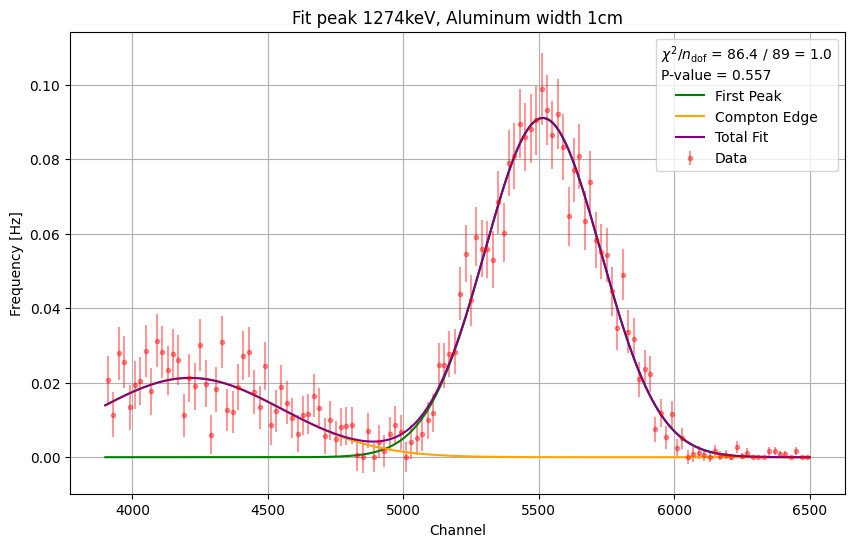

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 87.11 (χ²/ndof = 1.0)      │              Nfcn = 296              │
│ EDM = 5.57e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   49.6    │    1.1    │            │            │         │         │       │
│ 1 │ mu1    │  5.514e3  │  0.005e3  │            │            │         │         │       │
│ 2 │ sigma1 │    215    │     5     │            │            │         │         │       │
│ 3 │ A2     │    19     │     4     │            │            │         │         │       │
│ 4 │ mu2    │  4.21e3   │  0.09e3   │            │            │         │         │       │
│ 5 │ sigma2 │    340    │    60     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     1.13     -0.6      1.3     -0.5     10.0     -9.5 │
│    mu1 │     -0.6     27.1       -3        3      -59       57 │
│ sigma1 │      1.3       -3     20.4       -3       60      -61 │
│     A2 │     -0.5        3       -3     16.2     -347      220 │
│    mu2 │     10.0      -59       60     -347 8.42e+03   -4.8e3 │
│ sigma2 │     -9.5       57      -61      220   -4.8e3 3.48e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 49.56


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 88.01 (χ²/ndof = 1.0)      │              Nfcn = 281              │
│ EDM = 1.49e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   47.8    │    1.1    │            │            │         │         │       │
│ 1 │ mu1    │  5.516e3  │  0.005e3  │            │            │         │         │       │
│ 2 │ sigma1 │    212    │     5     │            │            │         │         │       │
│ 3 │ A2     │    18     │     4     │            │            │         │         │       │
│ 4 │ mu2    │  4.21e3   │  0.10e3   │            │            │         │         │       │
│ 5 │ sigma2 │    340    │    60     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     1.12     -0.6      1.3     -0.5      9.7     -9.3 │
│    mu1 │     -0.6     28.2       -3        3      -58       57 │
│ sigma1 │      1.3       -3     20.9       -3       58      -60 │
│     A2 │     -0.5        3       -3     15.4     -350      220 │
│    mu2 │      9.7      -58       58     -350 9.06e+03     -5e3 │
│ sigma2 │     -9.3       57      -60      220     -5e3  3.7e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 47.79
Errore statistico: 1.06
Errore sistematico: 0.89


In [9]:
# fit
N = 15
frequency_1 = frequency_converter(counts_1, time_signal=1200)
background_1 = SNIP_algorithm(frequency_1[0], iterations=N)
frequency_1 = (frequency_1[0] - background_1, frequency_1[1])

trapz_integral_1 = trapz_integral(channel_1, frequency_1, [4000, 5700])

ls = LeastSquares(channel_1, frequency_1[0], frequency_1[1], func2)
m = Minuit(ls, A1=trapz_integral_1*1.2, mu1=5300, sigma1=250, A2=trapz_integral_1*0.1, mu2=4200, sigma2=200)
ls.mask = (channel_1 > 4100) & (channel_1 < 6000)
m.migrad()
m.hesse()
display(m)

area_tot = m.values['A1']
err_area_tot = m.errors['A1']

print(f'Area picco con integrale trapezoidale: {trapz_integral_1:.2f}')
print(f'Area picco con integrale fit: {area_tot} ± {err_area_tot:.2f}')

intensità_1274_5KeV.append(area_tot)
err_intensità_1274_5KeV.append(err_area_tot)
intensità_trapz_1274_5KeV.append(trapz_integral_1)

# plot
plt.subplots(figsize=(10, 6))
plt.errorbar(channel_1[200:330], frequency_1[0][200:330], yerr=frequency_1[1][200:330], fmt='.', label='Data', color='red', alpha=0.4)
x = np.linspace(3900, 6500, 3000)
y1 = func(x, m.values['A1'], m.values['mu1'], m.values['sigma1'])
plt.plot(x, y1, label='First Peak', color='green')
y2 = func(x, m.values['A2'], m.values['mu2'], m.values['sigma2'])
plt.plot(x, y2, label='Compton Edge', color='orange')
y = func2(x, *m.values)
plt.plot(x, y, label='Total Fit', color='purple')
plt.xlabel('Channel')
plt.ylabel('Frequency [Hz]')
plt.title('Fit peak 1274keV, Aluminum width 1cm')
# metti chi2 ridotto in legenda
fit_info = [f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fval/m.ndof:.1f}",]
from scipy.stats import chi2
p_value = (1. - chi2.cdf(m.fval, df=m.ndof))
fit_info.append(f"P-value = {p_value:.3f}")
plt.legend(title="\n".join(fit_info), frameon=True)
plt.grid()
plt.show()

# calcolo errore sistematico DOWN
frequency_1 = frequency_converter(counts_1, time_signal=1200)
background_1 = SNIP_algorithm(frequency_1[0], iterations=N+1)
frequency_1 = (frequency_1[0] - background_1, frequency_1[1])

trapz_integral_1 = trapz_integral(channel_1, frequency_1, [4000, 5700])

ls = LeastSquares(channel_1, frequency_1[0], frequency_1[1], func2)
m = Minuit(ls, A1=trapz_integral_1*1.2, mu1=5300, sigma1=250, A2=trapz_integral_1*0.1, mu2=4200, sigma2=200)
ls.mask = (channel_1 > 4100) & (channel_1 < 6000)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_1 = frequency_converter(counts_1, time_signal=1200)
background_1 = SNIP_algorithm(frequency_1[0], iterations=N-1)
frequency_1 = (frequency_1[0] - background_1, frequency_1[1])

trapz_integral_1 = trapz_integral(channel_1, frequency_1, [4000, 5700])

ls = LeastSquares(channel_1, frequency_1[0], frequency_1[1], func2)
m = Minuit(ls, A1=trapz_integral_1*1.2, mu1=5300, sigma1=250, A2=trapz_integral_1*0.1, mu2=4200, sigma2=200)
ls.mask = (channel_1 > 4100) & (channel_1 < 6000)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_1274_5KeV.append(err_sistematico)
print(f'Errore statistico: {err_area_tot:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')


In [10]:
'''

    ALLUMINIO 1.4CM

'''

segnale_14cm = pd.read_csv(r'C:\Users\Black\Desktop\Esperimentazioni di Nucleare e Subnucleare\SiPM\Spettrometria Gamma\BGO\Alluminio\Data\1.4cm.csv', sep=' \t', engine='python')
channel_14 = np.array(segnale_14cm['Channel'])
counts_14 = np.array(segnale_14cm['Counts'])

# calculating frequency and removing background noise
frequency_14 = frequency_converter(counts_14, time_signal=1200)
background_14 = SNIP_algorithm(frequency_14[0], iterations=15)
frequency_14 = (frequency_14[0] - background_14, frequency_14[1])

# plot
fig = px.line(x=channel_14, y=frequency_14[0], error_y=frequency_14[1], title='Spettro Na con alluminio di spessore 1.4cm', labels={'x':'Canale', 'y':'Frequenza [Hz]'})
fig.show()

trapz_integral_14 = trapz_integral(channel_14, frequency_14, [1700, 2650])

ls = LeastSquares(channel_14, frequency_14[0], frequency_14[1], func2)
m = Minuit(ls, A1=trapz_integral_14, mu1=2300, sigma1=400, A2=trapz_integral_14*0.1, mu2=2000, sigma2=100)
ls.mask = (channel_14 > 1670) & (channel_14 < 2790)
m.migrad()
m.hesse()
display(m)

area_tot = m.values['A1'] + m.values['A2']
err_area_tot = np.sqrt(m.errors['A1']**2 + m.errors['A2']**2)

print(f'Area picco con integrale trapezoidale: {trapz_integral_14:.2f}')
print(f'Area picco con integrale fit: {area_tot} ± {err_area_tot:.2f}')

intensità_511KeV.append(area_tot)
err_intensità_511KeV.append(err_area_tot)
intensità_trapz_511KeV.append(trapz_integral_14)


# calcolo errore sistematico DOWN
frequency_14 = frequency_converter(counts_14, time_signal=1200)
background_14 = SNIP_algorithm(frequency_14[0], iterations=16)
frequency_14 = (frequency_14[0] - background_14, frequency_14[1])

trapz_integral_14 = trapz_integral(channel_14, frequency_14, [1700, 2650])

ls = LeastSquares(channel_14, frequency_14[0], frequency_14[1], func2)
m = Minuit(ls, A1=trapz_integral_14, mu1=2300, sigma1=400, A2=trapz_integral_14*0.1, mu2=2000, sigma2=100)
ls.mask = (channel_14 > 1670) & (channel_14 < 2790)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_14 = frequency_converter(counts_14, time_signal=1200)
background_14 = SNIP_algorithm(frequency_14[0], iterations=14)
frequency_14 = (frequency_14[0] - background_14, frequency_14[1])

trapz_integral_14 = trapz_integral(channel_14, frequency_14, [1700, 2650])

ls = LeastSquares(channel_14, frequency_14[0], frequency_14[1], func2)
m = Minuit(ls, A1=trapz_integral_14, mu1=2300, sigma1=400, A2=trapz_integral_14*0.1, mu2=2000, sigma2=100)
ls.mask = (channel_14 > 1670) & (channel_14 < 2790)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_511KeV.append(err_sistematico)
print(f'Errore statistico: {err_area_tot:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 64.64 (χ²/ndof = 1.3)      │              Nfcn = 362              │
│ EDM = 5.05e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    275    │    15     │            │            │         │         │       │
│ 1 │ mu1    │  2.310e3  │  0.004e3  │            │            │         │         │       │
│ 2 │ sigma1 │   127.7   │    2.4    │            │            │         │         │       │
│ 3 │ A2     │    94     │    15     │            │            │         │         │       │
│ 4 │ mu2    │  2.084e3  │  0.028e3  │            │            │         │         │       │
│ 5 │ sigma2 │    188    │    11     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────┐
│        │      A1     mu1  sigma1      A2     mu2  sigma2 │
├────────┼─────────────────────────────────────────────────┤
│     A1 │     221     -43      29 -0.21e3 -0.41e3 -0.09e3 │
│    mu1 │     -43    13.6      -7      41      74       1 │
│ sigma1 │      29      -7     5.6     -27     -49      -5 │
│     A2 │ -0.21e3      41     -27     213  0.40e3  0.09e3 │
│    mu2 │ -0.41e3      74     -49  0.40e3     810  0.18e3 │
│ sigma2 │ -0.09e3       1      -5  0.09e3  0.18e3     127 │
└────────┴─────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 365.94
Area picco con integrale fit: 369.10601586855734 ± 20.84


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 67.91 (χ²/ndof = 1.4)      │              Nfcn = 365              │
│ EDM = 5.77e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    289    │    12     │            │            │         │         │       │
│ 1 │ mu1    │ 2.3065e3  │ 0.0031e3  │            │            │         │         │       │
│ 2 │ sigma1 │   130.3   │    2.1    │            │            │         │         │       │
│ 3 │ A2     │    96     │    12     │            │            │         │         │       │
│ 4 │ mu2    │  2.047e3  │  0.026e3  │            │            │         │         │       │
│ 5 │ sigma2 │    204    │    12     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────┐
│        │      A1     mu1  sigma1      A2     mu2  sigma2 │
├────────┼─────────────────────────────────────────────────┤
│     A1 │     143     -27      20 -0.13e3 -0.30e3 -0.08e3 │
│    mu1 │     -27    9.38      -5      26      57       1 │
│ sigma1 │      20      -5    4.58     -19     -41      -5 │
│     A2 │ -0.13e3      26     -19     137  0.29e3  0.08e3 │
│    mu2 │ -0.30e3      57     -41  0.29e3     693  0.17e3 │
│ sigma2 │ -0.08e3       1      -5  0.08e3  0.17e3     140 │
└────────┴─────────────────────────────────────────────────┘

Area picco con integrale fit: 384.87


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 58.88 (χ²/ndof = 1.2)      │              Nfcn = 557              │
│ EDM = 5.81e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    98     │    21     │            │            │         │         │       │
│ 1 │ mu1    │  2.120e3  │  0.032e3  │            │            │         │         │       │
│ 2 │ sigma1 │    170    │    11     │            │            │         │         │       │
│ 3 │ A2     │    257    │    21     │            │            │         │         │       │
│ 4 │ mu2    │  2.317e3  │  0.005e3  │            │            │         │         │       │
│ 5 │ sigma2 │   124.5   │    2.7    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │      430    0.7e3   0.15e3   -0.4e3       82      -46 │
│    mu1 │    0.7e3 1.05e+03   0.25e3   -0.7e3      117      -65 │
│ sigma1 │   0.15e3   0.25e3      128  -0.14e3        8       -8 │
│     A2 │   -0.4e3   -0.7e3  -0.14e3      439      -84       47 │
│    mu2 │       82      117        8      -84     23.6      -12 │
│ sigma2 │      -46      -65       -8       47      -12     7.49 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 354.94
Errore statistico: 20.84
Errore sistematico: 14.96


In [11]:
# fit
N = 15
frequency_14 = frequency_converter(counts_14, time_signal=1200)
background_14 = SNIP_algorithm(frequency_14[0], iterations=N)
frequency_14 = (frequency_14[0] - background_14, frequency_14[1])

trapz_integral_14 = trapz_integral(channel_14, frequency_14, [4000, 5700])

ls = LeastSquares(channel_14, frequency_14[0], frequency_14[1], func2)
m = Minuit(ls, A1=trapz_integral_14*1.2, mu1=5300, sigma1=400, A2=trapz_integral_14*0.1, mu2=4200, sigma2=800)
ls.mask = (channel_14 > 4100) & (channel_14 < 6000)
m.migrad()
m.hesse()
display(m)

area_tot = m.values['A1']
err_area_tot = m.errors['A1']

print(f'Area picco con integrale trapezoidale: {trapz_integral_14:.2f}')
print(f'Area picco con integrale fit: {area_tot} ± {err_area_tot:.2f}')

intensità_1274_5KeV.append(area_tot)
err_intensità_1274_5KeV.append(err_area_tot)
intensità_trapz_1274_5KeV.append(trapz_integral_14)


# calcolo errore sistematico DOWN
frequency_14 = frequency_converter(counts_14, time_signal=1200)
background_14 = SNIP_algorithm(frequency_14[0], iterations=N+1)
frequency_14 = (frequency_14[0] - background_14, frequency_14[1])

trapz_integral_14 = trapz_integral(channel_14, frequency_14, [4000, 5700])

ls = LeastSquares(channel_14, frequency_14[0], frequency_14[1], func2)
m = Minuit(ls, A1=trapz_integral_14*1.2, mu1=5300, sigma1=400, A2=trapz_integral_14*0.1, mu2=4200, sigma2=800)
ls.mask = (channel_14 > 4100) & (channel_14 < 6000)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_14 = frequency_converter(counts_14, time_signal=1200)
background_14 = SNIP_algorithm(frequency_14[0], iterations=N-1)
frequency_14 = (frequency_14[0] - background_14, frequency_14[1])

trapz_integral_14 = trapz_integral(channel_14, frequency_14, [4000, 5700])

ls = LeastSquares(channel_14, frequency_14[0], frequency_14[1], func2)
m = Minuit(ls, A1=trapz_integral_14*1.2, mu1=5300, sigma1=400, A2=trapz_integral_14*0.1, mu2=4200, sigma2=800)
ls.mask = (channel_14 > 4100) & (channel_14 < 6000)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_1274_5KeV.append(err_sistematico)

print(f'Errore statistico: {err_area_tot:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 83.27 (χ²/ndof = 0.9)      │              Nfcn = 395              │
│ EDM = 5.09e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   45.9    │    1.0    │            │            │         │         │       │
│ 1 │ mu1    │  5.514e3  │  0.006e3  │            │            │         │         │       │
│ 2 │ sigma1 │    220    │     5     │            │            │         │         │       │
│ 3 │ A2     │   17.1    │    2.5    │            │            │         │         │       │
│ 4 │ mu2    │  4.27e3   │  0.05e3   │            │            │         │         │       │
│ 5 │ sigma2 │    290    │    40     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     1.05     -0.7      1.3     -0.3      4.0     -5.2 │
│    mu1 │     -0.7     31.4       -5        2      -30       39 │
│ sigma1 │      1.3       -5     22.6       -2       31      -42 │
│     A2 │     -0.3        2       -2     6.17     -117       92 │
│    mu2 │      4.0      -30       31     -117 2.93e+03   -1.9e3 │
│ sigma2 │     -5.2       39      -42       92   -1.9e3 1.72e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 51.14
Area picco con integrale fit: 45.92484682940072 ± 1.02


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 82.37 (χ²/ndof = 0.9)      │              Nfcn = 323              │
│ EDM = 1.2e-06 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   46.7    │    1.0    │            │            │         │         │       │
│ 1 │ mu1    │  5.512e3  │  0.006e3  │            │            │         │         │       │
│ 2 │ sigma1 │    222    │     5     │            │            │         │         │       │
│ 3 │ A2     │   17.5    │    2.5    │            │            │         │         │       │
│ 4 │ mu2    │  4.27e3   │  0.05e3   │            │            │         │         │       │
│ 5 │ sigma2 │    290    │    40     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     1.05     -0.7      1.3     -0.3      4.1     -5.3 │
│    mu1 │     -0.7     30.9       -5        2      -30       40 │
│ sigma1 │      1.3       -5     22.5       -2       32      -43 │
│     A2 │     -0.3        2       -2     6.26     -116       91 │
│    mu2 │      4.1      -30       32     -116 2.83e+03   -1.8e3 │
│ sigma2 │     -5.3       40      -43       91   -1.8e3 1.68e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 46.67


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 84.28 (χ²/ndof = 0.9)      │              Nfcn = 348              │
│ EDM = 3.98e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   44.9    │    1.0    │            │            │         │         │       │
│ 1 │ mu1    │  5.516e3  │  0.006e3  │            │            │         │         │       │
│ 2 │ sigma1 │    218    │     5     │            │            │         │         │       │
│ 3 │ A2     │   16.7    │    2.5    │            │            │         │         │       │
│ 4 │ mu2    │  4.27e3   │  0.06e3   │            │            │         │         │       │
│ 5 │ sigma2 │    300    │    40     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     1.04     -0.7      1.3     -0.3      4.0     -5.2 │
│    mu1 │     -0.7     32.3       -5        2      -30       40 │
│ sigma1 │      1.3       -5     23.1       -2       31      -43 │
│     A2 │     -0.3        2       -2     6.15     -120       94 │
│    mu2 │      4.0      -30       31     -120 3.12e+03   -2.0e3 │
│ sigma2 │     -5.2       40      -43       94   -2.0e3  1.8e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 44.85
Errore statistico: 1.02
Errore sistematico: 0.91


In [12]:
'''

    ALLUMINIO 2CM

'''

segnale_2cm = pd.read_csv(r'C:\Users\Black\Desktop\Esperimentazioni di Nucleare e Subnucleare\SiPM\Spettrometria Gamma\BGO\Alluminio\Data\2cm.csv', sep=' \t', engine='python')
channel_2 = np.array(segnale_2cm['Channel'])
counts_2 = np.array(segnale_2cm['Counts'])

# calculating frequency and removing background noise
frequency_2 = frequency_converter(counts_2, time_signal=1500)
background_2= SNIP_algorithm(frequency_2[0], iterations=15)

frequency_2 = (frequency_2[0] - background_2, frequency_2[1])

# plot
fig = px.line(x=channel_2, y=frequency_2[0], error_y=frequency_2[1], title='Spettro Na con alluminio di spessore 2cm', labels={'x':'Canale', 'y':'Frequenza [Hz]'})
fig.show()

trapz_integral_2 = trapz_integral(channel_2, frequency_2, [1700, 2650])

ls = LeastSquares(channel_2, frequency_2[0], frequency_2[1], func3)
m = Minuit(ls, A1=trapz_integral_2, mu1=2300, sigma1=400, A2=trapz_integral_2*0.1, mu2=2000, sigma2=100, A3=trapz_integral_1*0.2, mu3=1700, sigma3=300)
ls.mask = (channel_2 > 1700) & (channel_2 < 2650)
m.migrad()
m.hesse()
display(m)

area_tot = m.values['A1'] + m.values['A2']
err_area_tot = np.sqrt(m.errors['A1']**2 + m.errors['A2']**2)

print(f'Area picco con integrale trapezoidale: {trapz_integral_2:.2f}')
print(f'Area picco con integrale fit: {area_tot} ± {err_area_tot:.2f}')

intensità_511KeV.append(area_tot)
err_intensità_511KeV.append(err_area_tot)
intensità_trapz_511KeV.append(trapz_integral_2)


# calcolo errore sistematico DOWN
frequency_2 = frequency_converter(counts_2, time_signal=1500)
background_2 = SNIP_algorithm(frequency_2[0], iterations=16)
frequency_2 = (frequency_2[0] - background_2, frequency_2[1])

trapz_integral_2 = trapz_integral(channel_2, frequency_2, [1700, 2650])

ls = LeastSquares(channel_2, frequency_2[0], frequency_2[1], func3)
m = Minuit(ls, A1=trapz_integral_2, mu1=2300, sigma1=400, A2=trapz_integral_2*0.1, mu2=2000, sigma2=100, A3=trapz_integral_1*0.2, mu3=1700, sigma3=300)
ls.mask = (channel_2 > 1700) & (channel_2 < 2650)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_2 = frequency_converter(counts_2, time_signal=1500)
background_2 = SNIP_algorithm(frequency_2[0], iterations=14)
frequency_2 = (frequency_2[0] - background_2, frequency_2[1])

trapz_integral_2 = trapz_integral(channel_2, frequency_2, [1700, 2650])

ls = LeastSquares(channel_2, frequency_2[0], frequency_2[1], func3)
m = Minuit(ls, A1=trapz_integral_2, mu1=2300, sigma1=400, A2=trapz_integral_2*0.1, mu2=2000, sigma2=100, A3=trapz_integral_1*0.2, mu3=1700, sigma3=300)
ls.mask = (channel_2 > 1700) & (channel_2 < 2650)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_511KeV.append(err_sistematico)
print(f'Errore statistico: {err_area_tot:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 43.13 (χ²/ndof = 1.1)      │             Nfcn = 2034              │
│ EDM = 0.000307 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    233    │    15     │            │            │         │         │       │
│ 1 │ mu1    │  2.317e3  │  0.004e3  │            │            │         │         │       │
│ 2 │ sigma1 │   123.7   │    2.3    │            │            │         │         │       │
│ 3 │ A2     │    92     │    15     │            │            │         │         │       │
│ 4 │ mu2    │  2.091e3  │  0.028e3  │            │            │         │         │       │
│ 5 │ sigma2 │    169    │    16     │            │            │         │         │       │
│ 6 │ A3     │   0.4e3   │   0.6e3   │            │            │         │         │       │
│ 7 │ mu3    │  1.22e3   │  0.21e3   │            │            │         │         │       │
│ 8 │ sigma3 │    210    │    80     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬──────────────────────────────────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2       A3      mu3   sigma3 │
├────────┼──────────────────────────────────────────────────────────────────────────────────┤
│     A1 │      213      -48       23  -0.21e3  -0.39e3  -0.14e3   0.43e3   0.08e3  -0.09e3 │
│    mu1 │      -48     17.3       -8       43       90        7     -446      -50       99 │
│ sigma1 │       23       -8     5.12      -21      -41       -3      174       18      -38 │
│     A2 │  -0.21e3       43      -21      220   0.37e3   0.17e3   0.39e3   0.03e3  -0.10e3 │
│    mu2 │  -0.39e3       90      -41   0.37e3      765   0.23e3   -2.2e3   -0.3e3    0.5e3 │
│ sigma2 │  -0.14e3        7       -3   0.17e3   0.23e3      247   2.30e3   0.22e3  -0.53e3 │
│     A3 │   0.43e3     -446      174   0.39e3   -2.2e3   2.30e3 3.83e+05  -0.09e6     -6e3 │
│    mu3 │   0.08e3      -50       18   0.03e3   -0.3e3   0.22e3  -0.09e6 4.42e+04    -11e3 │
│ sigma3 │  -0.09e3       99      -38  -0.10e3    0.5e3  -0.53e3     -6e3    -11e3 7.09e+03 │
└────────┴──────────────────────────────────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 326.66
Area picco con integrale fit: 324.8994852586651 ± 20.83


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 38.92 (χ²/ndof = 1.0)      │             Nfcn = 1207              │
│ EDM = 2.18e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    227    │    33     │            │            │         │         │       │
│ 1 │ mu1    │  2.321e3  │  0.010e3  │            │            │         │         │       │
│ 2 │ sigma1 │    123    │     4     │            │            │         │         │       │
│ 3 │ A2     │    98     │    29     │            │            │         │         │       │
│ 4 │ mu2    │  2.12e3   │  0.07e3   │            │            │         │         │       │
│ 5 │ sigma2 │    163    │    26     │            │            │         │         │       │
│ 6 │ A3     │  0.06e3   │  0.12e3   │            │            │         │         │       │
│ 7 │ mu3    │   1.6e3   │   0.8e3   │            │            │         │         │       │
│ 8 │ sigma3 │  0.28e3   │  0.26e3   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬──────────────────────────────────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2       A3      mu3   sigma3 │
├────────┼──────────────────────────────────────────────────────────────────────────────────┤
│     A1 │ 1.08e+03     -290      125   -0.7e3   -2.1e3   -0.1e3    1.7e3  -12.9e3    1.8e3 │
│    mu1 │     -290     98.3      -40      130      640      -80     -740   5.72e3     -930 │
│ sigma1 │      125      -40     18.2      -62     -262       25      268 -2.082e3      320 │
│     A2 │   -0.7e3      130      -62      853    1.0e3    0.5e3   -0.1e3   -1.2e3   -1.0e3 │
│    mu2 │   -2.1e3      640     -262    1.0e3 4.76e+03   -0.4e3     -5e3     39e3     -5e3 │
│ sigma2 │   -0.1e3      -80       25    0.5e3   -0.4e3      695    1.8e3  -14.3e3    2.3e3 │
│     A3 │    1.7e3     -740      268   -0.1e3     -5e3    1.8e3 1.53e+04 -0.098e6  0.029e6 │
│    mu3 │  -12.9e3   5.72e3 -2.082e3   -1.2e3     39e3  -14.3e3 -0.098e6 6.73e+05  -0.16e6 │
│ sigma3 │    1.8e3     -930      320   -1.0e3     -5e3    2.3e3  0.029e6  -0.16e6 6.76e+04 │
└────────┴──────────────────────────────────────────────────────────────────────────────────┘

Area picco con integrale fit: 324.30


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 46.05 (χ²/ndof = 1.2)      │             Nfcn = 1671              │
│ EDM = 3.04e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    229    │    24     │            │            │         │         │       │
│ 1 │ mu1    │  2.317e3  │  0.006e3  │            │            │         │         │       │
│ 2 │ sigma1 │   122.6   │    2.9    │            │            │         │         │       │
│ 3 │ A2     │    85     │    25     │            │            │         │         │       │
│ 4 │ mu2    │  2.10e3   │  0.05e3   │            │            │         │         │       │
│ 5 │ sigma2 │    163    │    20     │            │            │         │         │       │
│ 6 │ A3     │     5     │    17     │            │            │         │         │       │
│ 7 │ mu3    │  1.68e3   │  0.20e3   │            │            │         │         │       │
│ 8 │ sigma3 │    60     │    90     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬──────────────────────────────────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2       A3      mu3   sigma3 │
├────────┼──────────────────────────────────────────────────────────────────────────────────┤
│     A1 │      592     -130       60   -0.6e3   -1.1e3   -0.4e3   0.01e3        0        0 │
│    mu1 │     -130     36.3      -16      130      250       80       10      -60       40 │
│ sigma1 │       60      -16     8.67      -59     -107      -32       -2       27      -17 │
│     A2 │   -0.6e3      130      -59      605    1.1e3    0.4e3  -0.01e3        0   -0.1e3 │
│    mu2 │   -1.1e3      250     -107    1.1e3  2.1e+03    0.8e3       -0   -0.2e3       -0 │
│ sigma2 │   -0.4e3       80      -32    0.4e3    0.8e3      402  -0.04e3    0.3e3   -0.3e3 │
│     A3 │   0.01e3       10       -2  -0.01e3       -0  -0.04e3      282  -3.36e3   1.52e3 │
│    mu3 │        0      -60       27        0   -0.2e3    0.3e3  -3.36e3 4.09e+04    -18e3 │
│ sigma3 │        0       40      -17   -0.1e3       -0   -0.3e3   1.52e3    -18e3 8.76e+03 │
└────────┴──────────────────────────────────────────────────────────────────────────────────┘

Area picco con integrale fit: 314.05
Errore statistico: 20.83
Errore sistematico: 5.13


In [13]:
# fit
N = 14
frequency_2 = frequency_converter(counts_2, time_signal=1500)
background_2 = SNIP_algorithm(frequency_2[0], iterations=N)
frequency_2 = (frequency_2[0] - background_2, frequency_2[1])

trapz_integral_2 = trapz_integral(channel_2, frequency_2, [4000, 5700])

ls = LeastSquares(channel_2, frequency_2[0], frequency_2[1], func2)
m = Minuit(ls, A1=trapz_integral_2*1.2, mu1=5500, sigma1=180, A2=trapz_integral_2*0.1, mu2=4250, sigma2=300)
ls.mask = (channel_2 > 4200) & (channel_2 < 6000)
m.migrad()
m.hesse()
display(m)

area_tot = m.values['A1']
err_area_tot = m.errors['A1']

xaxis = np.linspace(4000, 7000, 3000)
yaxis = func2(xaxis, *m.values)

print(f'Area picco con integrale trapezoidale: {trapz_integral_2:.2f}')
print(f'Area picco con integrale fit: {area_tot} ± {err_area_tot:.2f}')

intensità_1274_5KeV.append(area_tot)
err_intensità_1274_5KeV.append(err_area_tot)
intensità_trapz_1274_5KeV.append(trapz_integral_2)


# calcolo errore sistematico DOWN
frequency_2 = frequency_converter(counts_2, time_signal=1500)
background_2 = SNIP_algorithm(frequency_2[0], iterations=N+1)
frequency_2 = (frequency_2[0] - background_2, frequency_2[1])

trapz_integral_2 = trapz_integral(channel_2, frequency_2, [4000, 5700])

ls = LeastSquares(channel_2, frequency_2[0], frequency_2[1], func2)
m = Minuit(ls, A1=trapz_integral_2*1.2, mu1=5500, sigma1=180, A2=trapz_integral_2*0.1, mu2=4250, sigma2=300)
ls.mask = (channel_2 > 4200) & (channel_2 < 6000)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_2 = frequency_converter(counts_2, time_signal=1500)
background_2 = SNIP_algorithm(frequency_2[0], iterations=N-1)
frequency_2 = (frequency_2[0] - background_2, frequency_2[1])

trapz_integral_2 = trapz_integral(channel_2, frequency_2, [4000, 5700])

ls = LeastSquares(channel_2, frequency_2[0], frequency_2[1], func2)
m = Minuit(ls, A1=trapz_integral_2*1.2, mu1=5500, sigma1=180, A2=trapz_integral_2*0.1, mu2=4250, sigma2=300)
ls.mask = (channel_2 > 4200) & (channel_2 < 6000)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_1274_5KeV.append(err_sistematico)
print(f'Errore statistico: {err_area_tot:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 77.59 (χ²/ndof = 0.9)      │              Nfcn = 255              │
│ EDM = 2.66e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   41.0    │    0.9    │            │            │         │         │       │
│ 1 │ mu1    │  5.527e3  │  0.005e3  │            │            │         │         │       │
│ 2 │ sigma1 │    218    │     5     │            │            │         │         │       │
│ 3 │ A2     │   11.7    │    1.7    │            │            │         │         │       │
│ 4 │ mu2    │  4.38e3   │  0.05e3   │            │            │         │         │       │
│ 5 │ sigma2 │    260    │    40     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │    0.782     -0.6      1.2     -0.2      2.8     -4.6 │
│    mu1 │     -0.6     28.7       -4      1.3      -22       37 │
│ sigma1 │      1.2       -4     22.9     -1.6       24      -44 │
│     A2 │     -0.2      1.3     -1.6     3.06    -69.6     62.3 │
│    mu2 │      2.8      -22       24    -69.6 2.37e+03   -1.6e3 │
│ sigma2 │     -4.6       37      -44     62.3   -1.6e3 1.68e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 44.38
Area picco con integrale fit: 41.01940301003878 ± 0.88


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 78.3 (χ²/ndof = 0.9)       │              Nfcn = 257              │
│ EDM = 2.04e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   41.9    │    0.9    │            │            │         │         │       │
│ 1 │ mu1    │  5.526e3  │  0.005e3  │            │            │         │         │       │
│ 2 │ sigma1 │    220    │     5     │            │            │         │         │       │
│ 3 │ A2     │   12.0    │    1.8    │            │            │         │         │       │
│ 4 │ mu2    │  4.38e3   │  0.05e3   │            │            │         │         │       │
│ 5 │ sigma2 │    260    │    40     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │    0.785     -0.6      1.2     -0.2      2.8     -4.6 │
│    mu1 │     -0.6     27.9       -4      1.3      -22       36 │
│ sigma1 │      1.2       -4     22.4     -1.6       25      -44 │
│     A2 │     -0.2      1.3     -1.6     3.15    -70.0     62.3 │
│    mu2 │      2.8      -22       25    -70.0 2.31e+03   -1.5e3 │
│ sigma2 │     -4.6       36      -44     62.3   -1.5e3 1.62e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 41.92


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 76.58 (χ²/ndof = 0.9)      │              Nfcn = 244              │
│ EDM = 8.94e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   39.7    │    0.9    │            │            │         │         │       │
│ 1 │ mu1    │  5.529e3  │  0.005e3  │            │            │         │         │       │
│ 2 │ sigma1 │    216    │     5     │            │            │         │         │       │
│ 3 │ A2     │   11.4    │    1.8    │            │            │         │         │       │
│ 4 │ mu2    │  4.38e3   │  0.05e3   │            │            │         │         │       │
│ 5 │ sigma2 │    270    │    40     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     0.78     -0.6      1.3     -0.2      3.0     -4.9 │
│    mu1 │     -0.6       30       -5      1.4      -24       40 │
│ sigma1 │      1.3       -5     23.8     -1.6       26      -47 │
│     A2 │     -0.2      1.4     -1.6      3.1    -73.1     65.8 │
│    mu2 │      3.0      -24       26    -73.1 2.58e+03   -1.7e3 │
│ sigma2 │     -4.9       40      -47     65.8   -1.7e3 1.85e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 39.68
Errore statistico: 0.88
Errore sistematico: 1.12


In [14]:
'''

    ALLUMINIO 2.4CM

'''

segnale_24cm = pd.read_csv(r'C:\Users\Black\Desktop\Esperimentazioni di Nucleare e Subnucleare\SiPM\Spettrometria Gamma\BGO\Alluminio\Data\2.4cm.csv', sep=' \t', engine='python')
channel_24 = np.array(segnale_24cm['Channel'])
counts_24 = np.array(segnale_24cm['Counts'])

# calculating frequency and removing background noise
frequency_24 = frequency_converter(counts_24, time_signal=3300)
background_24 = SNIP_algorithm(frequency_24[0], iterations=15)

frequency_24 = (frequency_24[0] - background_24, frequency_24[1])

fig = px.line(x=channel_24, y=frequency_24[0], error_y=frequency_24[1], title='Spettro Na con alluminio di spessore 2.4cm', labels={'x':'Canale', 'y':'Frequenza [Hz]'})
fig.show()

# fit
trapz_integral_24 = trapz_integral(channel_24, frequency_24, [1700, 2650])

ls = LeastSquares(channel_24, frequency_24[0], frequency_24[1], func2)
m = Minuit(ls, A1=trapz_integral_24, mu1=2300, sigma1=128, A2=trapz_integral_24*0.1, mu2=2000, sigma2=200)
ls.mask = (channel_24 > 1700) & (channel_24 < 2750)
m.migrad()
m.hesse()
display(m)

area_tot = m.values['A1'] + m.values['A2'] 
err_area_tot = np.sqrt(m.errors['A1']**2 + m.errors['A2']**2)

print(f'Area picco con integrale trapezoidale: {trapz_integral_24:.2f}')
print(f'Area picco con integrale fit: {area_tot} ± {err_area_tot:.2f}')

intensità_511KeV.append(area_tot)
err_intensità_511KeV.append(err_area_tot)
intensità_trapz_511KeV.append(trapz_integral_24)


# calcolo errore sistematico DOWN
frequency_24 = frequency_converter(counts_24, time_signal=3300)
background_24 = SNIP_algorithm(frequency_24[0], iterations=16)
frequency_24 = (frequency_24[0] - background_24, frequency_24[1])

trapz_integral_24 = trapz_integral(channel_24, frequency_24, [1700, 2650])

ls = LeastSquares(channel_24, frequency_24[0], frequency_24[1], func2)
m = Minuit(ls, A1=trapz_integral_24, mu1=2300, sigma1=128, A2=trapz_integral_24*0.1, mu2=2000, sigma2=200)
ls.mask = (channel_24 > 1700) & (channel_24 < 2750)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_24 = frequency_converter(counts_24, time_signal=3300)
background_24 = SNIP_algorithm(frequency_24[0], iterations=14)
frequency_24 = (frequency_24[0] - background_24, frequency_24[1])

trapz_integral_24 = trapz_integral(channel_24, frequency_24, [1700, 2650])

ls = LeastSquares(channel_24, frequency_24[0], frequency_24[1], func2)
m = Minuit(ls, A1=trapz_integral_24, mu1=2300, sigma1=128, A2=trapz_integral_24*0.1, mu2=2000, sigma2=200)
ls.mask = (channel_24 > 1700) & (channel_24 < 2750)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_511KeV.append(err_sistematico)
print(f'Errore statistico: {err_area_tot:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 123.5 (χ²/ndof = 2.7)      │              Nfcn = 342              │
│ EDM = 5.65e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    228    │     7     │            │            │         │         │       │
│ 1 │ mu1    │ 2.3064e3  │ 0.0022e3  │            │            │         │         │       │
│ 2 │ sigma1 │   128.3   │    1.5    │            │            │         │         │       │
│ 3 │ A2     │    79     │     6     │            │            │         │         │       │
│ 4 │ mu2    │  2.039e3  │  0.018e3  │            │            │         │         │       │
│ 5 │ sigma2 │    201    │     8     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────┐
│        │     A1    mu1 sigma1     A2    mu2 sigma2 │
├────────┼───────────────────────────────────────────┤
│     A1 │   42.4    -11    7.5    -40   -110    -30 │
│    mu1 │    -11   4.66   -2.5     10     28      1 │
│ sigma1 │    7.5   -2.5   2.16   -7.0  -18.8   -2.6 │
│     A2 │    -40     10   -7.0   41.1    110     40 │
│    mu2 │   -110     28  -18.8    110    314     80 │
│ sigma2 │    -30      1   -2.6     40     80   72.3 │
└────────┴───────────────────────────────────────────┘

Area picco con integrale trapezoidale: 301.61
Area picco con integrale fit: 306.5008826833986 ± 9.14


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 126.5 (χ²/ndof = 2.7)      │              Nfcn = 339              │
│ EDM = 6.82e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    236    │     6     │            │            │         │         │       │
│ 1 │ mu1    │ 2.3041e3  │ 0.0019e3  │            │            │         │         │       │
│ 2 │ sigma1 │   130.3   │    1.4    │            │            │         │         │       │
│ 3 │ A2     │    88     │     6     │            │            │         │         │       │
│ 4 │ mu2    │  2.004e3  │  0.016e3  │            │            │         │         │       │
│ 5 │ sigma2 │    214    │     9     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────┐
│        │     A1    mu1 sigma1     A2    mu2 sigma2 │
├────────┼───────────────────────────────────────────┤
│     A1 │   33.5     -8    6.2    -31    -87    -30 │
│    mu1 │     -8   3.74   -2.0      8     23      2 │
│ sigma1 │    6.2   -2.0   1.92   -5.7  -16.3   -3.0 │
│     A2 │    -31      8   -5.7   33.3     82     36 │
│    mu2 │    -87     23  -16.3     82    259     70 │
│ sigma2 │    -30      2   -3.0     36     70   77.9 │
└────────┴───────────────────────────────────────────┘

Area picco con integrale fit: 323.93


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 115.5 (χ²/ndof = 2.5)      │              Nfcn = 350              │
│ EDM = 1.47e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    216    │     8     │            │            │         │         │       │
│ 1 │ mu1    │ 2.3103e3  │ 0.0026e3  │            │            │         │         │       │
│ 2 │ sigma1 │   125.7   │    1.6    │            │            │         │         │       │
│ 3 │ A2     │    74     │     8     │            │            │         │         │       │
│ 4 │ mu2    │  2.079e3  │  0.020e3  │            │            │         │         │       │
│ 5 │ sigma2 │    183    │     8     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────┐
│        │     A1    mu1 sigma1     A2    mu2 sigma2 │
├────────┼───────────────────────────────────────────┤
│     A1 │   67.5    -17   10.7    -60   -160    -40 │
│    mu1 │    -17   6.93   -3.6     17     39      2 │
│ sigma1 │   10.7   -3.6   2.66  -10.2  -23.4   -2.7 │
│     A2 │    -60     17  -10.2   65.4    150     40 │
│    mu2 │   -160     39  -23.4    150    401    100 │
│ sigma2 │    -40      2   -2.7     40    100   68.2 │
└────────┴───────────────────────────────────────────┘

Area picco con integrale fit: 290.43
Errore statistico: 9.14
Errore sistematico: 16.75


In [15]:
# fit
N = 15
frequency_24 = frequency_converter(counts_24, time_signal=3300)
background_24 = SNIP_algorithm(frequency_24[0], iterations=N)
frequency_24 = (frequency_24[0] - background_24, frequency_24[1])

trapz_integral_24 = trapz_integral(channel_24, frequency_24, [4000, 5700])

ls = LeastSquares(channel_24, frequency_24[0], frequency_24[1], func2)
m = Minuit(ls, A1=trapz_integral_24*1.2, mu1=5500, sigma1=400, A2=trapz_integral_24*0.1, mu2=4200, sigma2=800)
ls.mask = (channel_24 > 4100) & (channel_24 < 6000)
m.migrad()
m.hesse()
display(m)

area_tot = m.values['A1']
err_area_tot = m.errors['A1']

print(f'Area picco con integrale trapezoidale: {trapz_integral_24:.2f}')
print(f'Area picco con integrale fit: {area_tot} ± {err_area_tot:.2f}')

intensità_1274_5KeV.append(area_tot)
err_intensità_1274_5KeV.append(err_area_tot)
intensità_trapz_1274_5KeV.append(trapz_integral_24)

# calcolo errore sistematico DOWN
frequency_24 = frequency_converter(counts_24, time_signal=3300)
background_24 = SNIP_algorithm(frequency_24[0], iterations=N+1)
frequency_24 = (frequency_24[0] - background_24, frequency_24[1])

trapz_integral_24 = trapz_integral(channel_24, frequency_24, [4000, 5700])

ls = LeastSquares(channel_24, frequency_24[0], frequency_24[1], func2)
m = Minuit(ls, A1=trapz_integral_24*1.2, mu1=5500, sigma1=400, A2=trapz_integral_24*0.1, mu2=4200, sigma2=800)
ls.mask = (channel_24 > 4100) & (channel_24 < 6000)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_24 = frequency_converter(counts_24, time_signal=3300)
background_24 = SNIP_algorithm(frequency_24[0], iterations=N-1)
frequency_24 = (frequency_24[0] - background_24, frequency_24[1])

trapz_integral_24 = trapz_integral(channel_24, frequency_24, [4000, 5700])

ls = LeastSquares(channel_24, frequency_24[0], frequency_24[1], func2)
m = Minuit(ls, A1=trapz_integral_24*1.2, mu1=5500, sigma1=400, A2=trapz_integral_24*0.1, mu2=4200, sigma2=800)
ls.mask = (channel_24 > 4100) & (channel_24 < 6000)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_1274_5KeV.append(err_sistematico)
print(f'Errore statistico: {err_area_tot:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 93.47 (χ²/ndof = 1.1)      │              Nfcn = 301              │
│ EDM = 8.95e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   39.4    │    0.6    │            │            │         │         │       │
│ 1 │ mu1    │  5.521e3  │  0.004e3  │            │            │         │         │       │
│ 2 │ sigma1 │   215.5   │    3.1    │            │            │         │         │       │
│ 3 │ A2     │   12.3    │    1.3    │            │            │         │         │       │
│ 4 │ mu2    │  4.28e3   │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │    283    │    28     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │    0.336    -0.23     0.49    -0.05     0.95    -1.39 │
│    mu1 │    -0.23       13       -2      0.4       -8       11 │
│ sigma1 │     0.49       -2     9.66     -0.5        9      -13 │
│     A2 │    -0.05      0.4     -0.5     1.61    -39.8     30.8 │
│    mu2 │     0.95       -8        9    -39.8 1.41e+03   -0.8e3 │
│ sigma2 │    -1.39       11      -13     30.8   -0.8e3      785 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 41.15
Area picco con integrale fit: 39.38483897222645 ± 0.58


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 95.1 (χ²/ndof = 1.1)       │              Nfcn = 314              │
│ EDM = 4.51e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   40.0    │    0.6    │            │            │         │         │       │
│ 1 │ mu1    │  5.520e3  │  0.004e3  │            │            │         │         │       │
│ 2 │ sigma1 │   217.0   │    3.1    │            │            │         │         │       │
│ 3 │ A2     │   12.7    │    1.3    │            │            │         │         │       │
│ 4 │ mu2    │  4.27e3   │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │    285    │    28     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │    0.337    -0.23     0.49    -0.06     1.03    -1.46 │
│    mu1 │    -0.23     12.8       -2      0.5       -8       12 │
│ sigma1 │     0.49       -2     9.56     -0.5        9      -14 │
│     A2 │    -0.06      0.5     -0.5     1.72    -41.6     32.1 │
│    mu2 │     1.03       -8        9    -41.6 1.41e+03   -0.9e3 │
│ sigma2 │    -1.46       12      -14     32.1   -0.9e3      788 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 40.04


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 91.9 (χ²/ndof = 1.0)       │              Nfcn = 299              │
│ EDM = 2.99e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   38.4    │    0.6    │            │            │         │         │       │
│ 1 │ mu1    │  5.523e3  │  0.004e3  │            │            │         │         │       │
│ 2 │ sigma1 │   213.5   │    3.1    │            │            │         │         │       │
│ 3 │ A2     │   11.9    │    1.2    │            │            │         │         │       │
│ 4 │ mu2    │  4.28e3   │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │    284    │    28     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │    0.335    -0.24     0.50    -0.05     0.92    -1.36 │
│    mu1 │    -0.24     13.4       -2      0.4       -8       11 │
│ sigma1 │     0.50       -2     9.88     -0.5        8      -13 │
│     A2 │    -0.05      0.4     -0.5     1.56    -39.7     30.7 │
│    mu2 │     0.92       -8        8    -39.7 1.47e+03   -0.9e3 │
│ sigma2 │    -1.36       11      -13     30.7   -0.9e3      812 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 38.40
Errore statistico: 0.58
Errore sistematico: 0.82


In [16]:
'''

    ALLUMINIO 3CM

'''

segnale_3cm = pd.read_csv(r'C:\Users\Black\Desktop\Esperimentazioni di Nucleare e Subnucleare\SiPM\Spettrometria Gamma\BGO\Alluminio\Data\3cm.csv', sep=' \t', engine='python')
channel_3 = np.array(segnale_3cm['Channel'])
counts_3 = np.array(segnale_3cm['Counts'])

# calculating frequency and removing background noise
frequency_3 = frequency_converter(counts_3, time_signal=9000)
background_3 = SNIP_algorithm(frequency_3[0], iterations=15)

frequency_3 = (frequency_3[0] - background_3, frequency_3[1])

fig = px.line(x=channel_3, y=frequency_3[0], error_y=frequency_3[1], title='Spettro Na con alluminio di spessore 3cm', labels={'x':'Canale', 'y':'Frequenza [Hz]'})
fig.show()

# fit
trapz_integral_3 = trapz_integral(channel_3, frequency_3, [1700, 2650])

ls = LeastSquares(channel_3, frequency_3[0], frequency_3[1], func2)
m = Minuit(ls, A1=trapz_integral_3, mu1=2300, sigma1=400, A2=trapz_integral_3*0.1, mu2=2000, sigma2=100)
ls.mask = (channel_3 > 1700) & (channel_3 < 2650)
m.migrad()
m.hesse()
display(m)

area_tot = m.values['A1'] + m.values['A2']
err_area_tot = np.sqrt(m.errors['A1']**2 + m.errors['A2']**2)


print(f'Area picco con integrale trapezoidale: {trapz_integral_3:.2f}')
print(f'Area picco con integrale fit: {area_tot} ± {err_area_tot:.2f}')

intensità_511KeV.append(area_tot)
err_intensità_511KeV.append(err_area_tot)
intensità_trapz_511KeV.append(trapz_integral_3)


# calcolo errore sistematico DOWN
frequency_3 = frequency_converter(counts_3, time_signal=9000)
background_3 = SNIP_algorithm(frequency_3[0], iterations=16)
frequency_3 = (frequency_3[0] - background_3, frequency_3[1])

trapz_integral_3 = trapz_integral(channel_3, frequency_3, [1700, 2650])

ls = LeastSquares(channel_3, frequency_3[0], frequency_3[1], func2)
m = Minuit(ls, A1=trapz_integral_3, mu1=2300, sigma1=127, A2=trapz_integral_3*0.1, mu2=2050, sigma2=300)
ls.mask = (channel_3 > 1650) & (channel_3 < 2650)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_3 = frequency_converter(counts_3, time_signal=9000)
background_3 = SNIP_algorithm(frequency_3[0], iterations=14)
frequency_3 = (frequency_3[0] - background_3, frequency_3[1])

trapz_integral_3 = trapz_integral(channel_3, frequency_3, [1700, 2650])

ls = LeastSquares(channel_3, frequency_3[0], frequency_3[1], func2)
m = Minuit(ls, A1=trapz_integral_3, mu1=2300, sigma1=127, A2=trapz_integral_3*0.1, mu2=2050, sigma2=350)
ls.mask = (channel_3 > 1900) & (channel_3 < 2600)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_511KeV.append(err_sistematico)
print(f'Errore statistico: {err_area_tot:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 122.3 (χ²/ndof = 3.0)      │              Nfcn = 390              │
│ EDM = 6.97e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    189    │     4     │            │            │         │         │       │
│ 1 │ mu1    │ 2.3276e3  │ 0.0013e3  │            │            │         │         │       │
│ 2 │ sigma1 │   129.9   │    1.2    │            │            │         │         │       │
│ 3 │ A2     │    75     │     4     │            │            │         │         │       │
│ 4 │ mu2    │  2.031e3  │  0.014e3  │            │            │         │         │       │
│ 5 │ sigma2 │    226    │     9     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────┐
│        │     A1    mu1 sigma1     A2    mu2 sigma2 │
├────────┼───────────────────────────────────────────┤
│     A1 │   18.1   -3.7    4.0    -18    -59    -27 │
│    mu1 │   -3.7   1.67   -1.1    3.4   12.5    1.7 │
│ sigma1 │    4.0   -1.1   1.34   -4.0  -13.1   -4.3 │
│     A2 │    -18    3.4   -4.0   19.6     59     31 │
│    mu2 │    -59   12.5  -13.1     59    209     80 │
│ sigma2 │    -27    1.7   -4.3     31     80   72.4 │
└────────┴───────────────────────────────────────────┘

Area picco con integrale trapezoidale: 256.42
Area picco con integrale fit: 264.4307458158801 ± 6.14


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 150.8 (χ²/ndof = 3.5)      │              Nfcn = 355              │
│ EDM = 9.96e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    195    │     4     │            │            │         │         │       │
│ 1 │ mu1    │ 2.3248e3  │ 0.0011e3  │            │            │         │         │       │
│ 2 │ sigma1 │   132.2   │    1.1    │            │            │         │         │       │
│ 3 │ A2     │    92     │     4     │            │            │         │         │       │
│ 4 │ mu2    │  1.987e3  │  0.012e3  │            │            │         │         │       │
│ 5 │ sigma2 │    256    │     8     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────┐
│        │     A1    mu1 sigma1     A2    mu2 sigma2 │
├────────┼───────────────────────────────────────────┤
│     A1 │     13   -2.2    3.3    -13    -41    -21 │
│    mu1 │   -2.2   1.22   -0.8    2.0    8.2    0.4 │
│ sigma1 │    3.3   -0.8   1.24   -3.3  -10.6   -4.1 │
│     A2 │    -13    2.0   -3.3   15.3     41     27 │
│    mu2 │    -41    8.2  -10.6     41    148     60 │
│ sigma2 │    -21    0.4   -4.1     27     60   67.8 │
└────────┴───────────────────────────────────────────┘

Area picco con integrale fit: 286.44


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 45.79 (χ²/ndof = 1.6)      │             Nfcn = 1217              │
│ EDM = 7.02e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    192    │    14     │            │            │         │         │       │
│ 1 │ mu1    │  2.329e3  │  0.004e3  │            │            │         │         │       │
│ 2 │ sigma1 │   130.6   │    2.1    │            │            │         │         │       │
│ 3 │ A2     │    54     │    16     │            │            │         │         │       │
│ 4 │ mu2    │  2.04e3   │  0.05e3   │            │            │         │         │       │
│ 5 │ sigma2 │    180    │    40     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │      188      -55       25  -0.21e3  -0.61e3  -0.49e3 │
│    mu1 │      -55     17.5       -8       61      183      133 │
│ sigma1 │       25       -8     4.35      -28      -85      -59 │
│     A2 │  -0.21e3       61      -28      247   0.68e3   0.59e3 │
│    mu2 │  -0.61e3      183      -85   0.68e3 2.03e+03    1.5e3 │
│ sigma2 │  -0.49e3      133      -59   0.59e3    1.5e3 1.45e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 246.39
Errore statistico: 6.14
Errore sistematico: 20.02


In [17]:
# fit
N = 15
frequency_3 = frequency_converter(counts_3, time_signal=9000)
background_3 = SNIP_algorithm(frequency_3[0], iterations=N)
frequency_3 = (frequency_3[0] - background_3, frequency_3[1])

trapz_integral_3 = trapz_integral(channel_3, frequency_3, [4000, 5700])

ls = LeastSquares(channel_3, frequency_3[0], frequency_3[1], func2)
m = Minuit(ls, A1=trapz_integral_3*1.2, mu1=5500, sigma1=250, A2=trapz_integral_3*0.1, mu2=4200, sigma2=400)
ls.mask = (channel_3 > 4500) & (channel_3 < 6100)
m.migrad()
m.hesse()
display(m)

area_tot = m.values['A1']
err_area_tot = m.errors['A1']

print(f'Area picco con integrale trapezoidale: {trapz_integral_3:.2f}')
print(f'Area picco con integrale fit: {area_tot} ± {err_area_tot:.2f}')

intensità_1274_5KeV.append(area_tot)
err_intensità_1274_5KeV.append(err_area_tot)
intensità_trapz_1274_5KeV.append(trapz_integral_3)

# calcolo errore sistematico DOWN
frequency_3 = frequency_converter(counts_3, time_signal=9000)
background_3 = SNIP_algorithm(frequency_3[0], iterations=N+1)
frequency_3 = (frequency_3[0] - background_3, frequency_3[1])

trapz_integral_3 = trapz_integral(channel_3, frequency_3, [4000, 5700])

ls = LeastSquares(channel_3, frequency_3[0], frequency_3[1], func2)
m = Minuit(ls, A1=trapz_integral_3*1.2, mu1=5500, sigma1=250, A2=trapz_integral_3*0.1, mu2=4200, sigma2=400)
ls.mask = (channel_3 > 4500) & (channel_3 < 6100)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_3 = frequency_converter(counts_3, time_signal=9000)
background_3 = SNIP_algorithm(frequency_3[0], iterations=N-1)
frequency_3 = (frequency_3[0] - background_3, frequency_3[1])

trapz_integral_3 = trapz_integral(channel_3, frequency_3, [4000, 5700])

ls = LeastSquares(channel_3, frequency_3[0], frequency_3[1], func2)
m = Minuit(ls, A1=trapz_integral_3*1.2, mu1=5500, sigma1=250, A2=trapz_integral_3*0.1, mu2=4200, sigma2=400)
ls.mask = (channel_3 > 4500) & (channel_3 < 6100)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_1274_5KeV.append(err_sistematico)
print(f'Errore statistico: {err_area_tot:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 148 (χ²/ndof = 2.0)        │              Nfcn = 349              │
│ EDM = 5.16e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   34.60   │   0.33    │            │            │         │         │       │
│ 1 │ mu1    │ 5.5587e3  │ 0.0024e3  │            │            │         │         │       │
│ 2 │ sigma1 │   219.7   │    2.0    │            │            │         │         │       │
│ 3 │ A2     │    4.2    │    0.9    │            │            │         │         │       │
│ 4 │ mu2    │  4.54e3   │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │    144    │    25     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │    0.109    -0.10     0.16    -0.01     0.26    -0.24 │
│    mu1 │    -0.10     5.74       -1      0.1       -3        3 │
│ sigma1 │     0.16       -1      3.8     -0.1        4       -3 │
│     A2 │    -0.01      0.1     -0.1    0.852    -34.0     21.7 │
│    mu2 │     0.26       -3        4    -34.0 1.51e+03   -0.9e3 │
│ sigma2 │    -0.24        3       -3     21.7   -0.9e3      636 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 33.01
Area picco con integrale fit: 34.596906496430485 ± 0.33


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 150.4 (χ²/ndof = 2.0)      │              Nfcn = 336              │
│ EDM = 6.33e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   35.14   │   0.33    │            │            │         │         │       │
│ 1 │ mu1    │ 5.5577e3  │ 0.0024e3  │            │            │         │         │       │
│ 2 │ sigma1 │   220.8   │    1.9    │            │            │         │         │       │
│ 3 │ A2     │    4.4    │    1.0    │            │            │         │         │       │
│ 4 │ mu2    │  4.53e3   │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │    146    │    26     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │    0.109    -0.09     0.16    -0.01     0.28    -0.25 │
│    mu1 │    -0.09     5.63       -1      0.1       -3        3 │
│ sigma1 │     0.16       -1     3.72     -0.1        4       -4 │
│     A2 │    -0.01      0.1     -0.1     1.03    -39.4     24.3 │
│    mu2 │     0.28       -3        4    -39.4 1.65e+03   -0.9e3 │
│ sigma2 │    -0.25        3       -4     24.3   -0.9e3      654 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 35.14


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 144.5 (χ²/ndof = 2.0)      │              Nfcn = 354              │
│ EDM = 6.44e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   33.74   │   0.33    │            │            │         │         │       │
│ 1 │ mu1    │ 5.5599e3  │ 0.0024e3  │            │            │         │         │       │
│ 2 │ sigma1 │   217.9   │    2.0    │            │            │         │         │       │
│ 3 │ A2     │    4.0    │    0.9    │            │            │         │         │       │
│ 4 │ mu2    │  4.54e3   │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │    147    │    26     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────┐
│        │      A1     mu1  sigma1      A2     mu2  sigma2 │
├────────┼─────────────────────────────────────────────────┤
│     A1 │   0.109   -0.10    0.17   -0.01    0.27   -0.26 │
│    mu1 │   -0.10    5.94      -1     0.1      -3       3 │
│ sigma1 │    0.17      -1    3.91    -0.1       4      -4 │
│     A2 │   -0.01     0.1    -0.1   0.821   -34.2    22.0 │
│    mu2 │    0.27      -3       4   -34.2 1.6e+03  -0.9e3 │
│ sigma2 │   -0.26       3      -4    22.0  -0.9e3     679 │
└────────┴─────────────────────────────────────────────────┘

Area picco con integrale fit: 33.74
Errore statistico: 0.33
Errore sistematico: 0.70


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.387 (χ²/ndof = 0.3)      │              Nfcn = 42               │
│ EDM = 2.25e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │   0.205   │   0.022   │            │            │         │         │       │
│ 1 │ A    │    492    │    14     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────┐
│    │       mu        A │
├────┼───────────────────┤
│ mu │ 0.000479 232.4e-3 │
│  A │ 232.4e-3      210 │
└────┴───────────────────┘

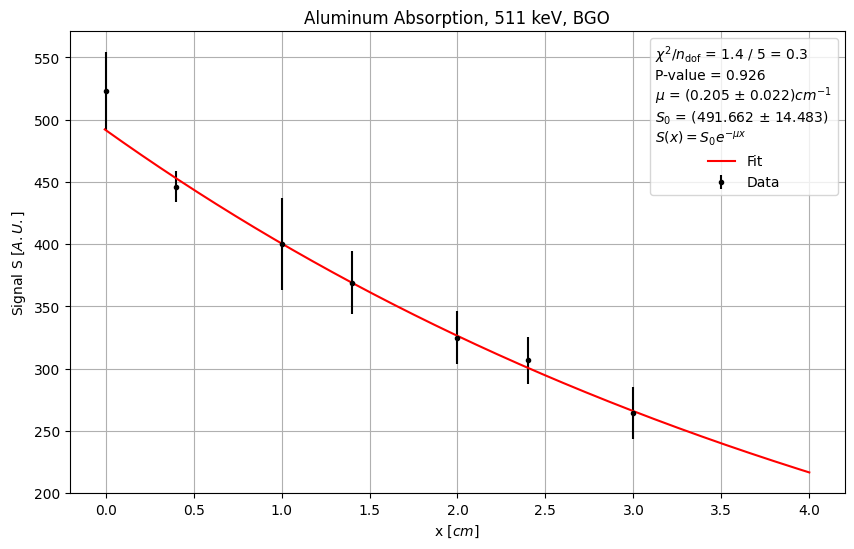

Coefficiente di assorbimento: 0.2051 ± 0.0219
Intensità: [522.8429865  446.21168427 400.28870691 369.10601587 324.89948526
 306.50088268 264.43074582]
Intensità err: [31.19477755 12.66704112 36.82098082 25.65160749 21.44825733 19.08516664
 20.94192625]
Spessori: [0.  0.4 1.  1.4 2.  2.4 3. ]

 Intensità trapezi: [521.1853616151454, 446.02387642523416, 398.74668821339105, 365.93983487598945, 326.6637604561204, 301.6111940430916, 256.41590567499475]
Compatibilità con 228: 1.047879368017896 sigma
P-value: 0.2946941891535193


In [18]:
'''

    FIT ASSORBIMENTO con 511KeV

'''

def assorbimento(x, mu, A):
    return A * np.exp(-mu * x)

spessori = np.array([0., 0.4, 1, 1.4, 2, 2.4, 3])
intensità = np.array(intensità_511KeV)
intensità_err = np.sqrt(np.array(err_intensità_511KeV)**2 + np.array(err_sistematico_511KeV)**2)

ls = LeastSquares(spessori, intensità, intensità_err, assorbimento)
m = Minuit(ls, mu=0.228, A=np.max(intensità))
m.migrad()
m.hesse()
display(m)

# plot
x_axis = np.linspace(-0.005, 4, 1000)
y = assorbimento(x_axis, m.values['mu'], m.values['A'])
plt.subplots(figsize=(10, 6))
plt.errorbar(spessori, intensità, intensità_err, marker='.', linestyle='', color='black', label='Data', ecolor='black')
plt.plot(x_axis, y, color='red', label='Fit')
fit_info = [f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {(m.fval/m.ndof):.1f}",]
p_value = (1. - chi2.cdf(m.fval, df=m.ndof))
fit_info.append(f"P-value = {p_value:.3f}")
fit_info.append(f'$\\mu$ = ({m.values["mu"]:.3f} $\\pm$ {m.errors["mu"]:.3f})' + '$cm^{-1}$')
fit_info.append(r'$S_0$' + f' = ({m.values["A"]:.3f} $\\pm$ {m.errors["A"]:.3f})')
fit_info.append(r'$S(x) = S_0 e^{- \mu x}$')
plt.legend(title="\n".join(fit_info), frameon=True)
plt.grid(True)
plt.title('Aluminum Absorption, 511 keV, BGO')
plt.xlabel('x $[cm]$')
plt.ylabel('Signal S $[A.U.]$')
plt.show()
print(f'Coefficiente di assorbimento: {m.values["mu"]:.4f} ± {m.errors["mu"]:.4f}')
print(f'Intensità: {intensità}')
print(f'Intensità err: {intensità_err}')
print(f'Spessori: {spessori}')
print(f'\n Intensità trapezi: {intensità_trapz_511KeV}')
t = abs(m.values["mu"] - 0.228)/m.errors["mu"]
print(f'Compatibilità con 228: {t} sigma')
from scipy.stats import norm
from scipy.integrate import quad
pvalue = 1 - (quad(norm.pdf, -t, t)[0])
print(f'P-value: {pvalue}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.9866 (χ²/ndof = 0.2)     │              Nfcn = 53               │
│ EDM = 5.47e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │   0.173   │   0.013   │            │            │         │         │       │
│ 1 │ A    │   58.5    │    1.6    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────┐
│    │       mu        A │
├────┼───────────────────┤
│ mu │ 0.000165 18.55e-3 │
│  A │ 18.55e-3     2.55 │
└────┴───────────────────┘

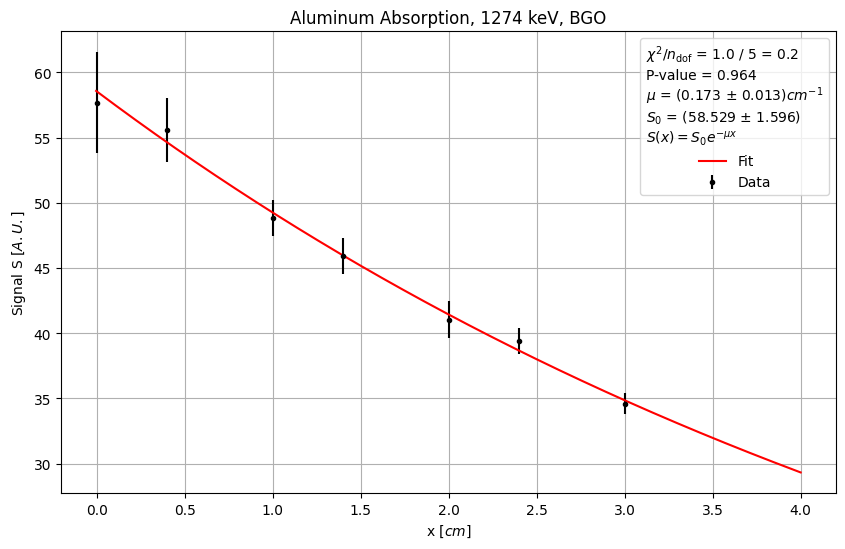

Coefficiente di assorbimento: 0.1729 ± 0.0128
Intensità: [57.69074544 55.58192683 48.85401366 45.92484683 41.01940301 39.38483897
 34.5969065 ]
Intensità err: [3.84083917 2.48866146 1.3809617  1.36725065 1.42610281 1.00491274
 0.77401828]
Spessori: [0.  0.4 1.  1.4 2.  2.4 3. ]
Compatibilità con 0.148: 1.937299586113845 sigma
P-value: 0.05270873283665045


In [19]:
'''

    FIT ASSORBIMENTO con 1274.5KeV

'''

intensità = np.array(intensità_1274_5KeV)
intensità_err = np.sqrt(np.array(err_intensità_1274_5KeV)**2 + np.array(err_sistematico_1274_5KeV)**2)

ls = LeastSquares(spessori, intensità, intensità_err, assorbimento)
m = Minuit(ls, mu=0.148, A=np.max(intensità))
m.migrad()
m.hesse()
display(m)

# plot
x_axis = np.linspace(-0.005, 4, 1000)
y = assorbimento(x_axis, m.values['mu'], m.values['A'])
plt.subplots(figsize=(10, 6))
plt.errorbar(spessori, intensità, intensità_err, marker='.', linestyle='', color='black', label='Data', ecolor='black')
plt.plot(x_axis, y, color='red', label='Fit')
fit_info = [f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {(m.fval/m.ndof):.1f}",]
p_value = (1. - chi2.cdf(m.fval, df=m.ndof))
fit_info.append(f"P-value = {p_value:.3f}")
fit_info.append(f'$\\mu$ = ({m.values["mu"]:.3f} $\\pm$ {m.errors["mu"]:.3f})' + '$cm^{-1}$')
fit_info.append(r'$S_0$' + f' = ({m.values["A"]:.3f} $\\pm$ {m.errors["A"]:.3f})')
fit_info.append(r'$S(x) = S_0 e^{- \mu x}$')
plt.legend(title="\n".join(fit_info), frameon=True)
plt.grid(True)
plt.title('Aluminum Absorption, 1274 keV, BGO')
plt.xlabel('x $[cm]$')
plt.ylabel('Signal S $[A.U.]$')
plt.show()
print(f'Coefficiente di assorbimento: {m.values["mu"]:.4f} ± {m.errors["mu"]:.4f}')
print(f'Intensità: {intensità}')
print(f'Intensità err: {intensità_err}')
print(f'Spessori: {spessori}')
t = abs(m.values["mu"] - 0.148)/m.errors["mu"]
print(f'Compatibilità con 0.148: {t} sigma')
pvalue = 1 - (quad(norm.pdf, -t, t)[0])
print(f'P-value: {pvalue}')